In [1]:
import numpy as np
#import keras
import tensorflow
from sklearn import metrics
from numpy import mean,std,dstack
from pandas import read_csv
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, TimeDistributed, Conv1D, MaxPooling1D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.utils import to_categorical,plot_model
import matplotlib.pyplot as plt
import os,csv

In [2]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '/device:GPU:0'

In [3]:
# 定义读取数据函数，转换为DataFrame数据结构，返回Numpy数组。
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

In [4]:
# 定义 pandas读取 UCI HAR 数据集中的所有数据的函数；
# 数组的维数为 [样本，时间步长，特征]（[sample，timestamp，features]）
# numpy 的 dstack()方法将输入数据按照第三维堆叠。
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = dstack(loaded)
    return loaded


In [5]:
# 加载数据集，返回数据集X和标签y
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # 加载所有9个文件转换为一维数组
    filenames = list()
    # 重力加速度信号
    filenames += ['total_acc_x_' + group + '.txt', 'total_acc_y_' + group + '.txt', 'total_acc_z_' + group + '.txt']
    # 身体加速度信号
    filenames += ['body_acc_x_' + group + '.txt', 'body_acc_y_' + group + '.txt', 'body_acc_z_' + group + '.txt']
    # 陀螺仪读取的身体角速度信号
    filenames += ['body_gyro_x_' + group + '.txt', 'body_gyro_y_' + group + '.txt', 'body_gyro_z_' + group + '.txt']
    # 加载输入数据
    X = load_group(filenames, filepath)
    # 加载分类标记
    y = load_file(prefix + group + '/y_' + group + '.txt')
    return X, y

In [6]:
# 加载数据集，并返回训练集和测试集
def load_dataset(prefix=''):
    # 加载训练数据集
    trainX, trainy = load_dataset_group('train', prefix + 'D:/GraduationCode/01 Datasets/UCI HAR Dataset/')
    print(trainX.shape, trainy.shape)
    # 加载测试数据集
    testX, testy = load_dataset_group('test', prefix + 'D:/GraduationCode/01 Datasets/UCI HAR Dataset/')
    print(testX.shape, testy.shape)
    # 原数据集标签为1到6，而one-hot编码中类别起始序号为0，减去一以使得分类数为6
    trainy = trainy - 1
    testy = testy - 1
    # 使用keras的方法对分类进行one-hot编码
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)

    print(trainX.shape, trainy.shape, testX.shape, testy.shape)
    return trainX, trainy, testX, testy


In [7]:
# 拟合评估模型
def evaluate_model(trainX, trainy, testX, testy):
    
    verbose, epochs, batch_size = 1, 100, 64
    #verbose, epochs, batch_size = 1, 5, 64
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    """
    CNN-LSTM模型将主序列的子序列作为块读取，从每个块中提取特征，然后让LSTM来解释从每个块中提取的特征。
    实现此模型的一种方法是将128个时间步长的窗口分割成子序列，以便CNN模型处理。
    例如，每个窗口中的128个时间步可以分成4个32个时间步的子序列。
    """
    n_steps, n_length = 4, 32
    
    trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
    testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features))
    
    # 定义模型
    # model = Sequential() #顺序模型
    # 在TF2.1使用tensorboard,需按照如下定义
    model = tensorflow.keras.Sequential()
    
    
    """
    CNN模型包装在TimeDistributed层中，
    以允许相同的CNN模型在窗口中读取四个子序列中的每个子序列。
    """
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None, n_length, n_features)))
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
    model.add(TimeDistributed(Dropout(0.5)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    """
    Flatten层用来将输入“压平”，即把多维的输入一维化，常用在从卷积层到全连接层的过渡。
    将一个维度大于或等于3的高维矩阵，“压扁”为一个二维矩阵。即保留第一个维度。
    """
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(100))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    # softmax激活函数：本质是离散概率分布，适用于多分类任务。
    model.add(Dense(n_outputs, activation='softmax'))
    
    # 编译模型
    """
    交叉熵损失衡量的是实际输出与期望输出的距离，交叉熵的值越小，两个概率分布就越接近。
    损失函数：二分类binary_crossentropy；
    多分类：categorial_crossentropy/sparse_categorical_crossentropy。
    """
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    print(model.summary()) # 控制台打印网络结构
    
    # 保存网络结构图
    plot_model(model,to_file='uci_har_CNN-LSTM.png',show_shapes=True,dpi=300)
    
    # 构造Tensorboard类的对象
    logdir = os.path.join('uci_har_cnn-lstm_logs2')
    summary = tensorflow.keras.callbacks.TensorBoard(log_dir=logdir,histogram_freq=1)
    history = model.fit(trainX, trainy, 
                      epochs=epochs, batch_size=batch_size, verbose=verbose, validation_data=(testX, testy),
                      callbacks=[summary])
    
    # 模型保存
    model.save('uci_har_cnn-lstm.h5')
    
    # 模型测试
    test_model(model, testX, verbose, batch_size, n_outputs)
    
    # 模型评估
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=verbose)

    model.evaluate(testX, testy, batch_size=batch_size)
    print("model.metrics_names:{}".format(model.metrics_names))
    print("history.history:{}".format(history.history))
    
    return accuracy,history


In [8]:
# 定义测试模型
def test_model(model, testX, verbose, batch_size, n_outputs):

    prediction_list = model.predict(testX, batch_size=batch_size, steps=None, verbose=verbose)
    predictions_transformed = np.eye(n_outputs, dtype=int)[np.argmax(prediction_list, axis=1)]

    np.savetxt('uci_har_cnn-lstm_predictions2.txt', prediction_list)
    np.savetxt('uci_har_cnn-lstm_predictions_trans2.txt', (np.argmax(predictions_transformed, axis=1)))

In [9]:
def plot_accuracy(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(acc) + 1)
    plt.figure(figsize=(6,6),dpi=200)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'orange', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

In [10]:
def plot_loss(history):
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.figure(figsize=(6,6),dpi=200)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'orange', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [11]:
# summarize scores
def summarize_results(scores):
    print(scores)
    m, s = mean(scores), std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

In [12]:
def plot_predictions():
    x = list(range(1, 101))
    actual = read_csv("D:/GraduationCode/01 Datasets/UCI HAR Dataset/test/y_test.txt", nrows=100, header=None, delim_whitespace=True)
    predicted = read_csv("uci_har_cnn-lstm_predictions_trans2.txt", nrows=100, header=None, delim_whitespace=True)
    predicted = ([x+1 for x in np.array(predicted)])
    plt.figure(figsize=(6,6),dpi=200)
    plt.plot(x, actual)
    plt.plot(x, predicted, color='r')
    plt.show()

    with open('D:/GraduationCode/01 Datasets/UCI HAR Dataset/test/y_test.txt', newline='') as csvfile:
        actualok = list(csv.reader(csvfile))

    with open('uci_har_cnn-lstm_predictions_trans2.txt', newline='') as csvfile:
        predictedok = list(csv.reader(csvfile))

    print("Confusion Matrix:")
    confusion_matrix = metrics.confusion_matrix(actualok, predictedok)
    print(confusion_matrix)
    
    normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

    width = 8
    height = 8
  
    plt.figure(figsize=(width, height),dpi=200)
    plt.imshow(
        normalised_confusion_matrix, 
        interpolation='nearest', 
        cmap=plt.cm.rainbow
    )
    plt.title("Confusion matrix \n(normalised to % of total test data)")


    print(normalised_confusion_matrix)

    LABELS = [
        "WALKING", 
        "WALKING_UPSTAIRS", 
        "WALKING_DOWNSTAIRS", 
        "SITTING", 
        "STANDING", 
        "LAYING"
    ]
    plt.colorbar() # 渐变色
    tick_marks = np.arange(6)
    plt.xticks(tick_marks, LABELS, rotation=90)
    plt.yticks(tick_marks, LABELS)
    plt.tight_layout() # 自动调整子图参数，使之填充整个图像区域。
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [13]:
def run_experiment(repeats=5):
    trainX, trainy, testX, testy = load_dataset()
    scores=list()
    for r in range(repeats):
        score,history = evaluate_model(trainX, trainy, testX, testy)
        score=score*100.0
        print("Accuracy : ", score)
        plot_predictions()
        plot_accuracy(history)
        plot_loss(history)

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, None, 30, 64)      1792      
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 28, 64)      12352     
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 28, 64)      0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 14, 64)      0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 896)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               398800    
______________________

7352/7352 [==============================] - 2s 309us/sample - loss: 0.0428 - accuracy: 0.9791 - val_loss: 0.5446 - val_accuracy: 0.9080
Epoch 45/100
7352/7352 [==============================] - 2s 310us/sample - loss: 0.0386 - accuracy: 0.9808 - val_loss: 0.5379 - val_accuracy: 0.8982
Epoch 46/100
7352/7352 [==============================] - 2s 307us/sample - loss: 0.0579 - accuracy: 0.9770 - val_loss: 0.4322 - val_accuracy: 0.9053
Epoch 47/100
7352/7352 [==============================] - 2s 306us/sample - loss: 0.0372 - accuracy: 0.9818 - val_loss: 0.5165 - val_accuracy: 0.9046
Epoch 48/100
7352/7352 [==============================] - 2s 309us/sample - loss: 0.0418 - accuracy: 0.9789 - val_loss: 0.4816 - val_accuracy: 0.9189
Epoch 49/100
7352/7352 [==============================] - 2s 308us/sample - loss: 0.0421 - accuracy: 0.9808 - val_loss: 0.4448 - val_accuracy: 0.9033
Epoch 50/100
7352/7352 [==============================] - 2s 308us/sample - loss: 0.0369 - accuracy: 0.9822 - val

Epoch 99/100
7352/7352 [==============================] - 2s 308us/sample - loss: 0.0444 - accuracy: 0.9887 - val_loss: 0.3773 - val_accuracy: 0.9284
Epoch 100/100
2947/2947 [==============================] - 0s 114us/sample - loss: 0.4147 - accuracy: 0.9270
model.metrics_names:['loss', 'accuracy']
history.history:{'loss': [0.6299835897828082, 0.23274353706765358, 0.1505906906980166, 0.1323809027428596, 0.11694057778707656, 0.11247739873591393, 0.11739744480306098, 0.11264242186445148, 0.10057539905505548, 0.1015743349189338, 0.09471547737377123, 0.09525086289683156, 0.10105507667617258, 0.10069542070516305, 0.08840649233678999, 0.08819099543241214, 0.10110730950247346, 0.08486992980924084, 0.07556950990049831, 0.08291788827891383, 0.07166144420859993, 0.07765088724509546, 0.06875154163214146, 0.0676864441261263, 0.06295771824279081, 0.06787869336653067, 0.06138468882366934, 0.05732057989859737, 0.06502252601500565, 0.06155965794830444, 0.05568430308451201, 0.05237728282322821, 0.05691

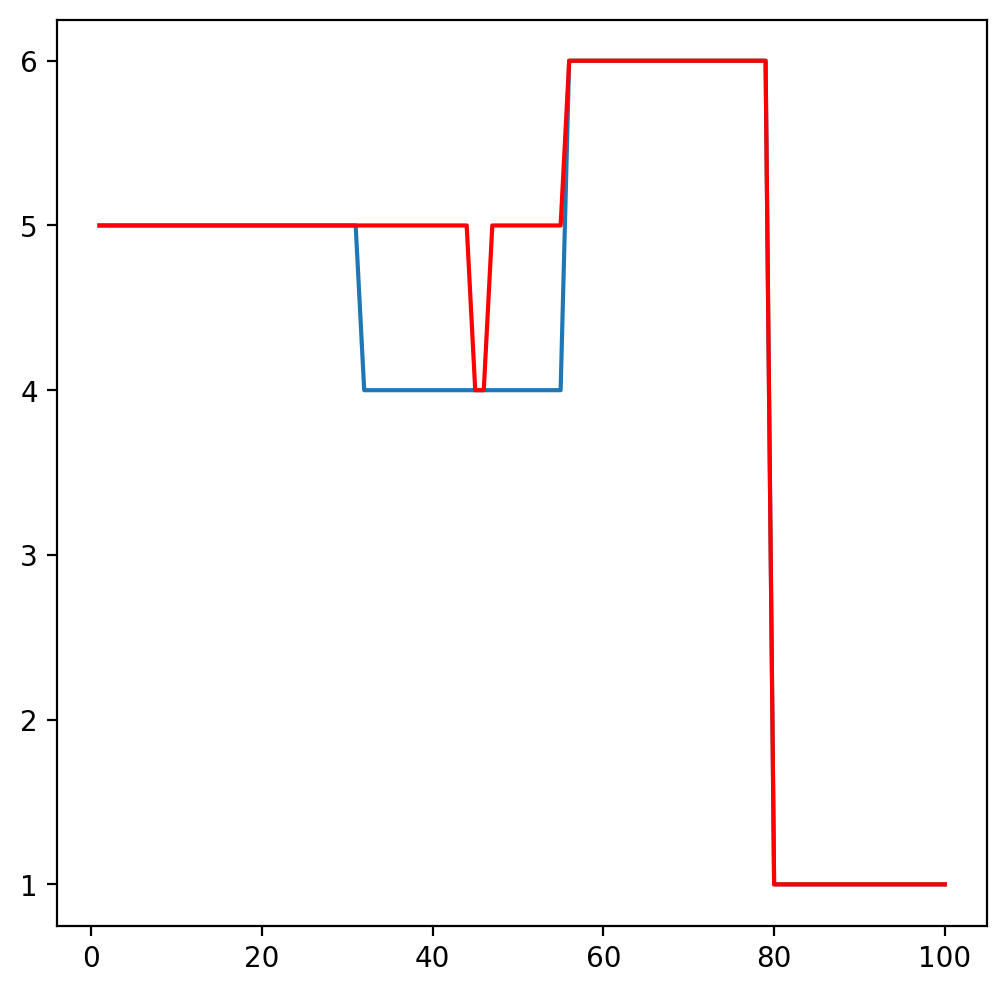

Confusion Matrix:
[[  0   0   0   0   0   0   0   0   0   0   0   0]
 [480   0   2   0  14   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  3   0 446   0  22   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  2   0   8   0 410   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  1   0   8   0   0   0 384   0  98   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  1   0   0   0   0   0  39   0 492   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  17   0   0   0   0   0   0   0 520   0]]
[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [16.28775     0.          0.06786563  0.          0.4750594   0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.    

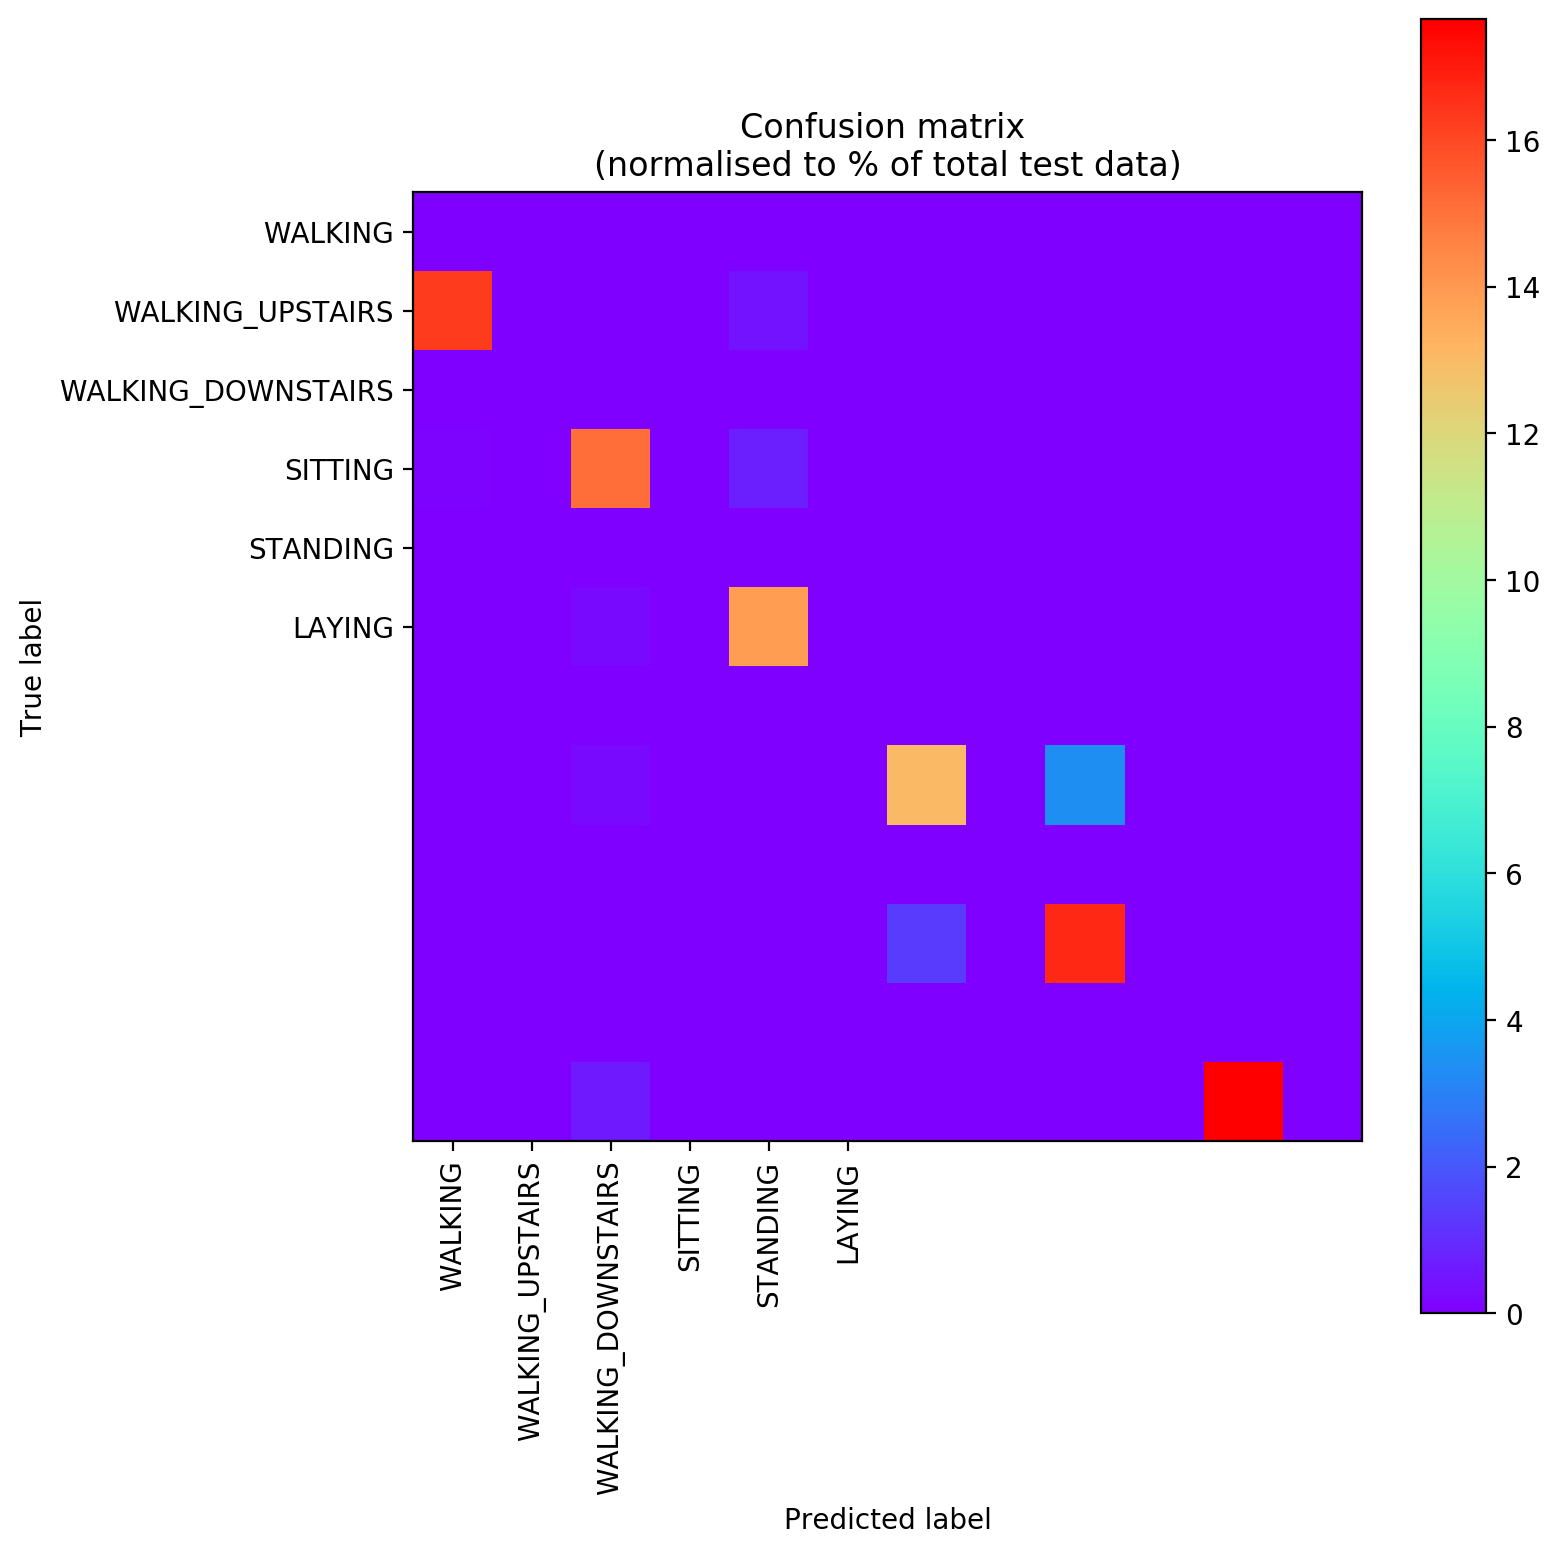

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_5 (TimeDist (None, None, 30, 64)      1792      
_________________________________________________________________
time_distributed_6 (TimeDist (None, None, 28, 64)      12352     
_________________________________________________________________
time_distributed_7 (TimeDist (None, None, 28, 64)      0         
_________________________________________________________________
time_distributed_8 (TimeDist (None, None, 14, 64)      0         
_________________________________________________________________
time_distributed_9 (TimeDist (None, None, 896)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               398800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)              

7352/7352 [==============================] - 2s 309us/sample - loss: 0.0497 - accuracy: 0.9750 - val_loss: 0.2979 - val_accuracy: 0.9230
Epoch 46/100
7352/7352 [==============================] - 2s 309us/sample - loss: 0.0438 - accuracy: 0.9773 - val_loss: 0.5117 - val_accuracy: 0.9135
Epoch 47/100
7352/7352 [==============================] - 2s 306us/sample - loss: 0.0392 - accuracy: 0.9803 - val_loss: 0.4816 - val_accuracy: 0.9097
Epoch 48/100
7352/7352 [==============================] - 2s 306us/sample - loss: 0.0417 - accuracy: 0.9807 - val_loss: 0.4866 - val_accuracy: 0.9101
Epoch 49/100
7352/7352 [==============================] - 2s 310us/sample - loss: 0.0465 - accuracy: 0.9773 - val_loss: 0.4074 - val_accuracy: 0.9097
Epoch 50/100
7352/7352 [==============================] - 2s 305us/sample - loss: 0.0391 - accuracy: 0.9801 - val_loss: 0.3961 - val_accuracy: 0.9158
Epoch 51/100
7352/7352 [==============================] - 2s 308us/sample - loss: 0.0523 - accuracy: 0.9770 - val

Epoch 100/100
2947/2947 [==============================] - 0s 119us/sample - loss: 0.6251 - accuracy: 0.9050
model.metrics_names:['loss', 'accuracy']
history.history:{'loss': [0.6495342933703558, 0.21137371902496951, 0.15412067750041192, 0.12423168125200583, 0.12012788907941978, 0.12706893333056546, 0.1109486064499688, 0.10458397798815801, 0.10277480350744478, 0.10136587848082201, 0.09734145455443431, 0.12277731429927367, 0.0940828763426842, 0.098013993259418, 0.09666744677980266, 0.09901164189159416, 0.09500635578677107, 0.08950226718278134, 0.08138723405517873, 0.08507446502056683, 0.09517622713133352, 0.08369078663896296, 0.07480253807803103, 0.08020446993921346, 0.08135759931410358, 0.07649327280715319, 0.06808362291544125, 0.0666292756309447, 0.06364512557044252, 0.06136023744908329, 0.06414533987787266, 0.06149556499554232, 0.05992999710081808, 0.0631206572396322, 0.06572189362024457, 0.05671195982285533, 0.05567801763608614, 0.05644679774471454, 0.05128802109400259, 0.0476219483

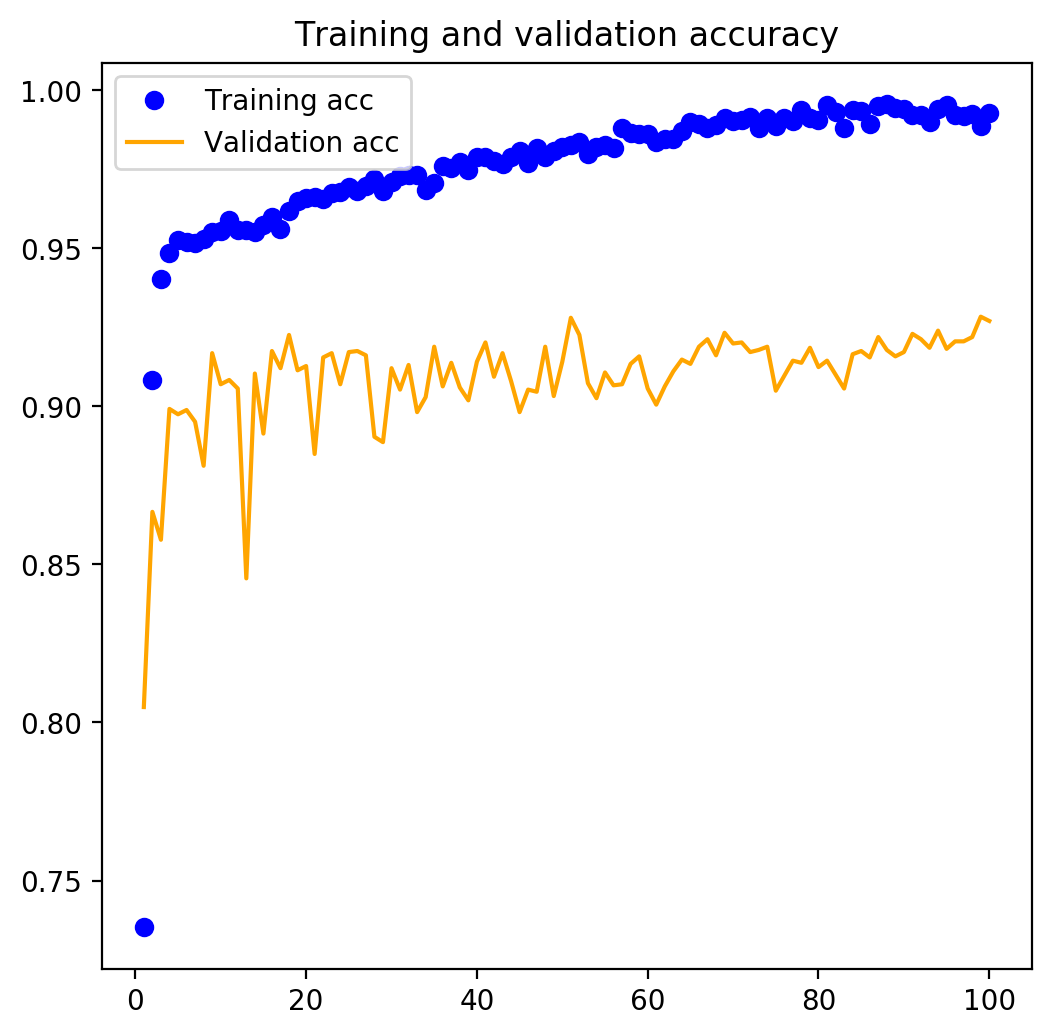

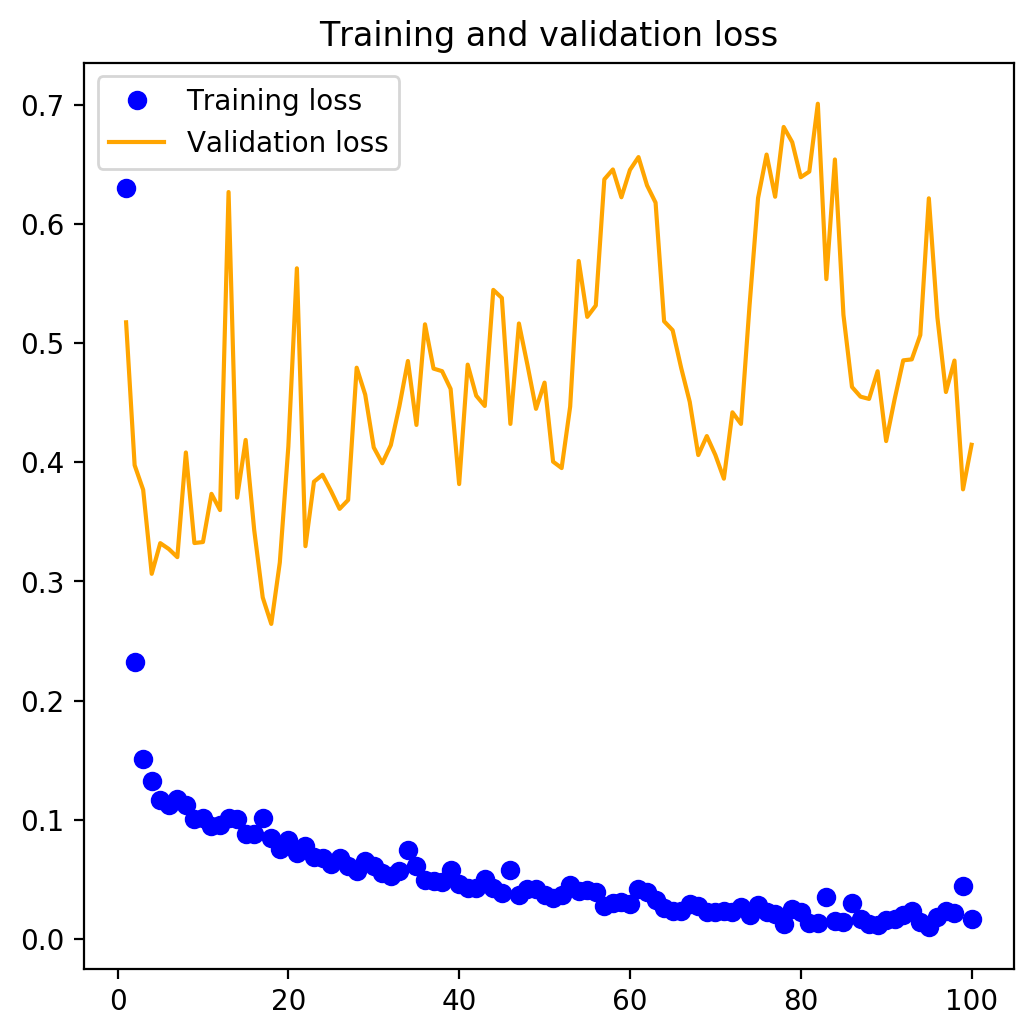

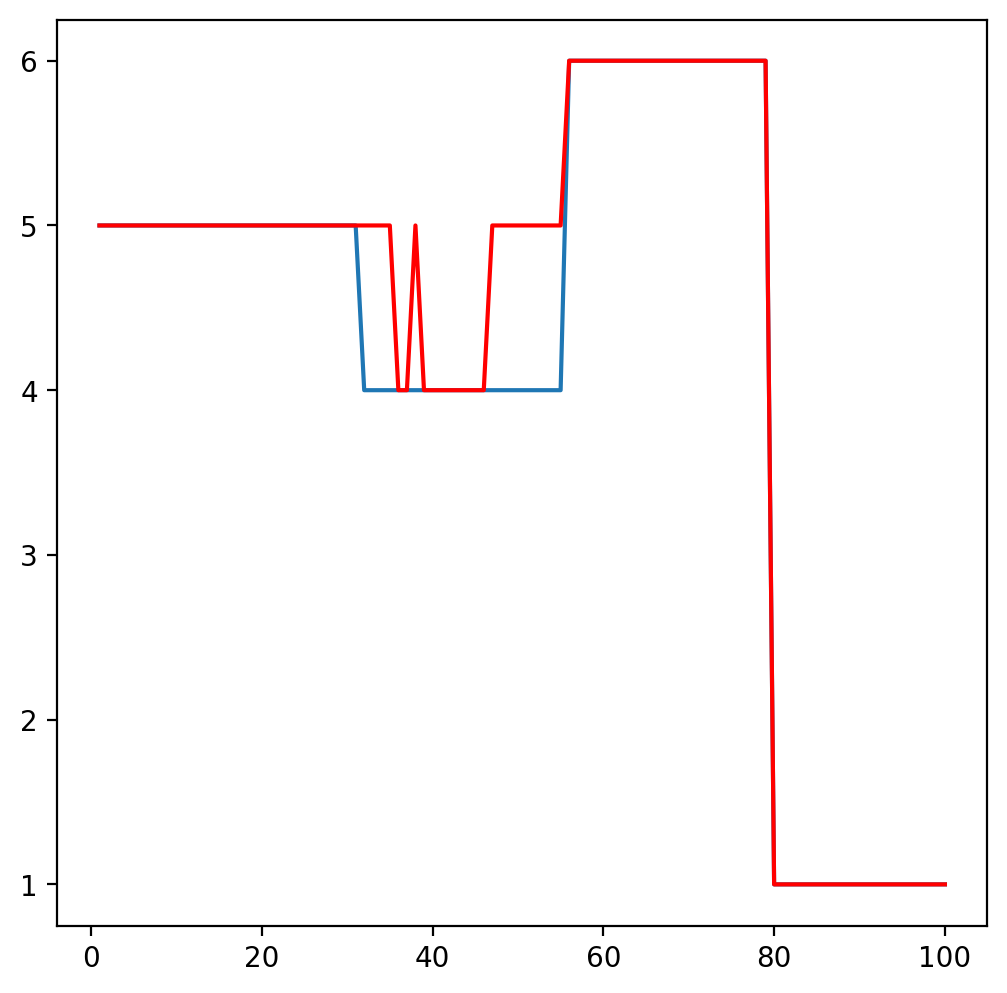

Confusion Matrix:
[[  0   0   0   0   0   0   0   0   0   0   0   0]
 [476   0   0   0  20   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0 448   0  23   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   1   0 419   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   5   0   0   0 397   0  89   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  1   0   0   0   0   0 114   0 417   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  27   0   0   0   0   0   0   0 510   0]]
[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [16.152018    0.          0.          0.          0.6786562   0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.    

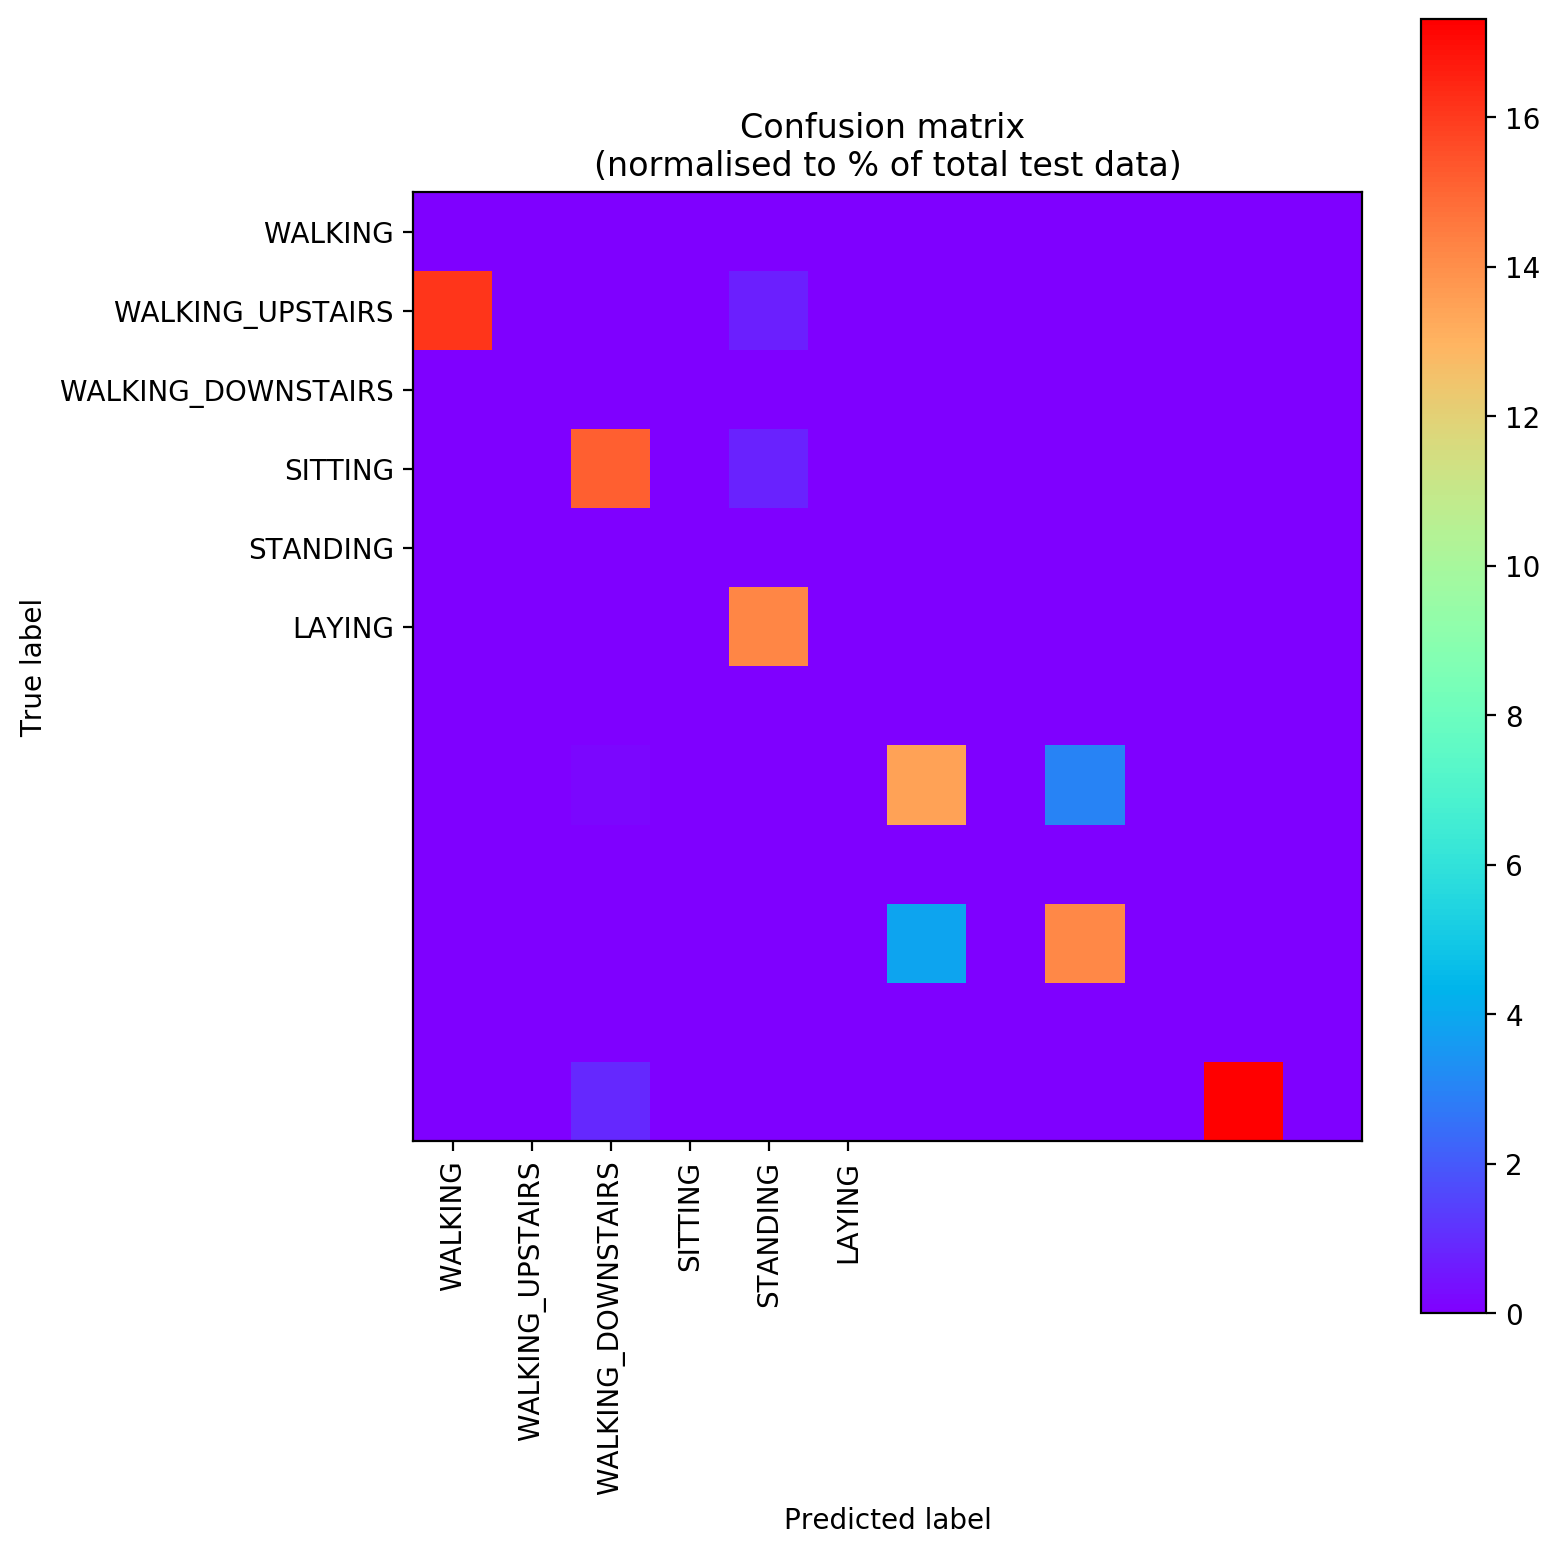

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_10 (TimeDis (None, None, 30, 64)      1792      
_________________________________________________________________
time_distributed_11 (TimeDis (None, None, 28, 64)      12352     
_________________________________________________________________
time_distributed_12 (TimeDis (None, None, 28, 64)      0         
_________________________________________________________________
time_distributed_13 (TimeDis (None, None, 14, 64)      0         
_________________________________________________________________
time_distributed_14 (TimeDis (None, None, 896)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               398800    
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)              

7352/7352 [==============================] - 2s 309us/sample - loss: 0.0417 - accuracy: 0.9819 - val_loss: 0.5679 - val_accuracy: 0.9175
Epoch 46/100
7352/7352 [==============================] - 2s 307us/sample - loss: 0.0335 - accuracy: 0.9830 - val_loss: 0.6568 - val_accuracy: 0.9114
Epoch 47/100
7352/7352 [==============================] - 2s 310us/sample - loss: 0.0374 - accuracy: 0.9844 - val_loss: 0.6472 - val_accuracy: 0.9087
Epoch 48/100
7352/7352 [==============================] - 2s 309us/sample - loss: 0.0375 - accuracy: 0.9822 - val_loss: 0.6018 - val_accuracy: 0.9169
Epoch 49/100
7352/7352 [==============================] - 2s 311us/sample - loss: 0.0369 - accuracy: 0.9853 - val_loss: 0.5546 - val_accuracy: 0.9182
Epoch 50/100
7352/7352 [==============================] - 2s 308us/sample - loss: 0.0300 - accuracy: 0.9872 - val_loss: 0.6408 - val_accuracy: 0.9128
Epoch 51/100
7352/7352 [==============================] - 2s 316us/sample - loss: 0.0373 - accuracy: 0.9823 - val

Epoch 100/100
2947/2947 [==============================] - 0s 110us/sample - loss: 0.4445 - accuracy: 0.9237
model.metrics_names:['loss', 'accuracy']
history.history:{'loss': [0.6248387830885243, 0.21492495935033273, 0.151343339237347, 0.13584949196163276, 0.12282815135374942, 0.11361623990782196, 0.10412317647581455, 0.10575629276212334, 0.10608508966465899, 0.09950924647710528, 0.09868208057083944, 0.08781677087661491, 0.08495884264238641, 0.09556360923815863, 0.0973220914521207, 0.0911125184135092, 0.07317698452625752, 0.06769547742812755, 0.07246611038601924, 0.06600735852569828, 0.057894902924021, 0.0676280788355735, 0.07740540855784087, 0.05971956822182071, 0.0555538632162118, 0.060050964197376995, 0.06067210873659858, 0.053814946216763165, 0.060175030327060536, 0.047709154141448655, 0.049572691938538874, 0.047219986019005455, 0.045195925801433015, 0.04555581052310286, 0.043681798557526914, 0.03671082998250973, 0.05508315312281916, 0.058153685853209534, 0.04520908346697607, 0.040

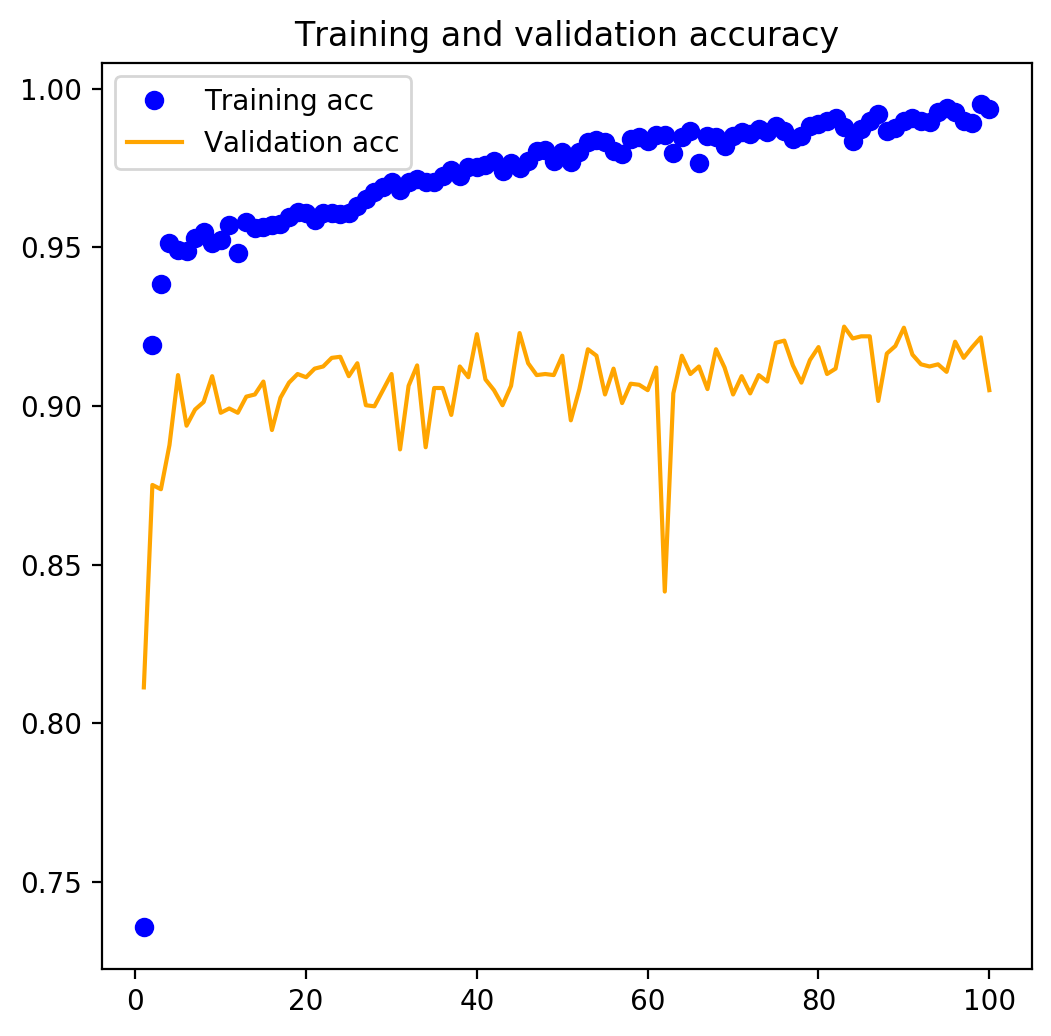

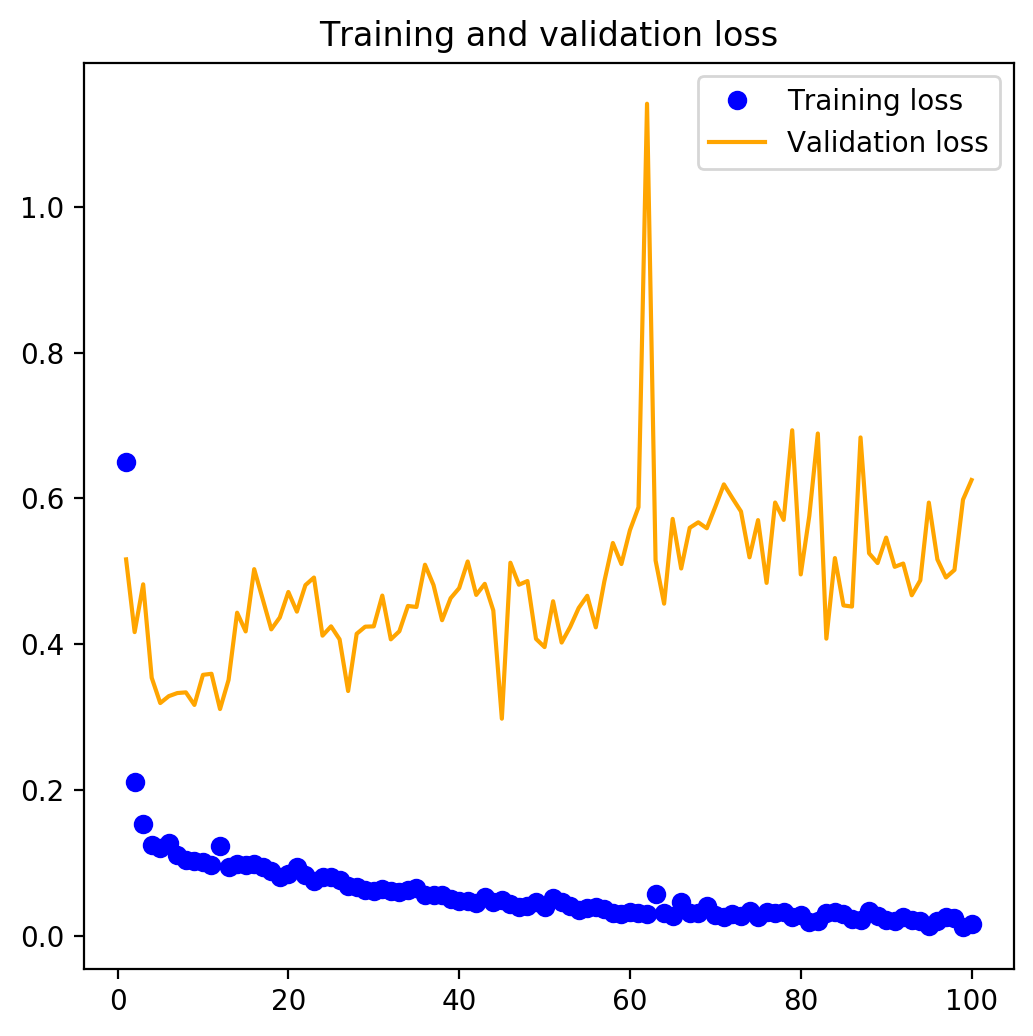

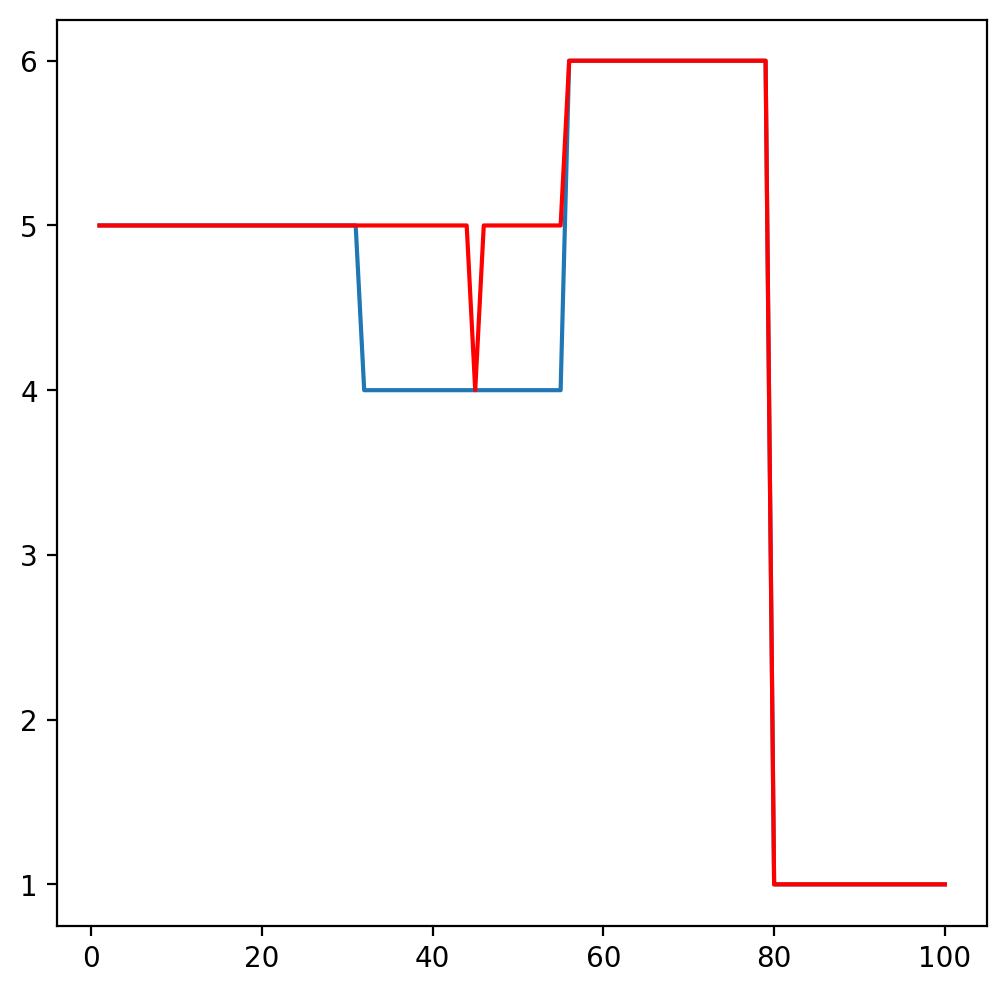

Confusion Matrix:
[[  0   0   0   0   0   0   0   0   0   0   0   0]
 [464   0   8   0  23   0   0   0   1   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  1   0 446   0  24   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  4   0   0   0 416   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  12   0   0   0 387   0  92   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  33   0 499   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  27   0   0   0   0   0   0   0 510   0]]
[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [15.744824    0.          0.2714625   0.          0.7804547   0.
   0.          0.          0.03393281  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.    

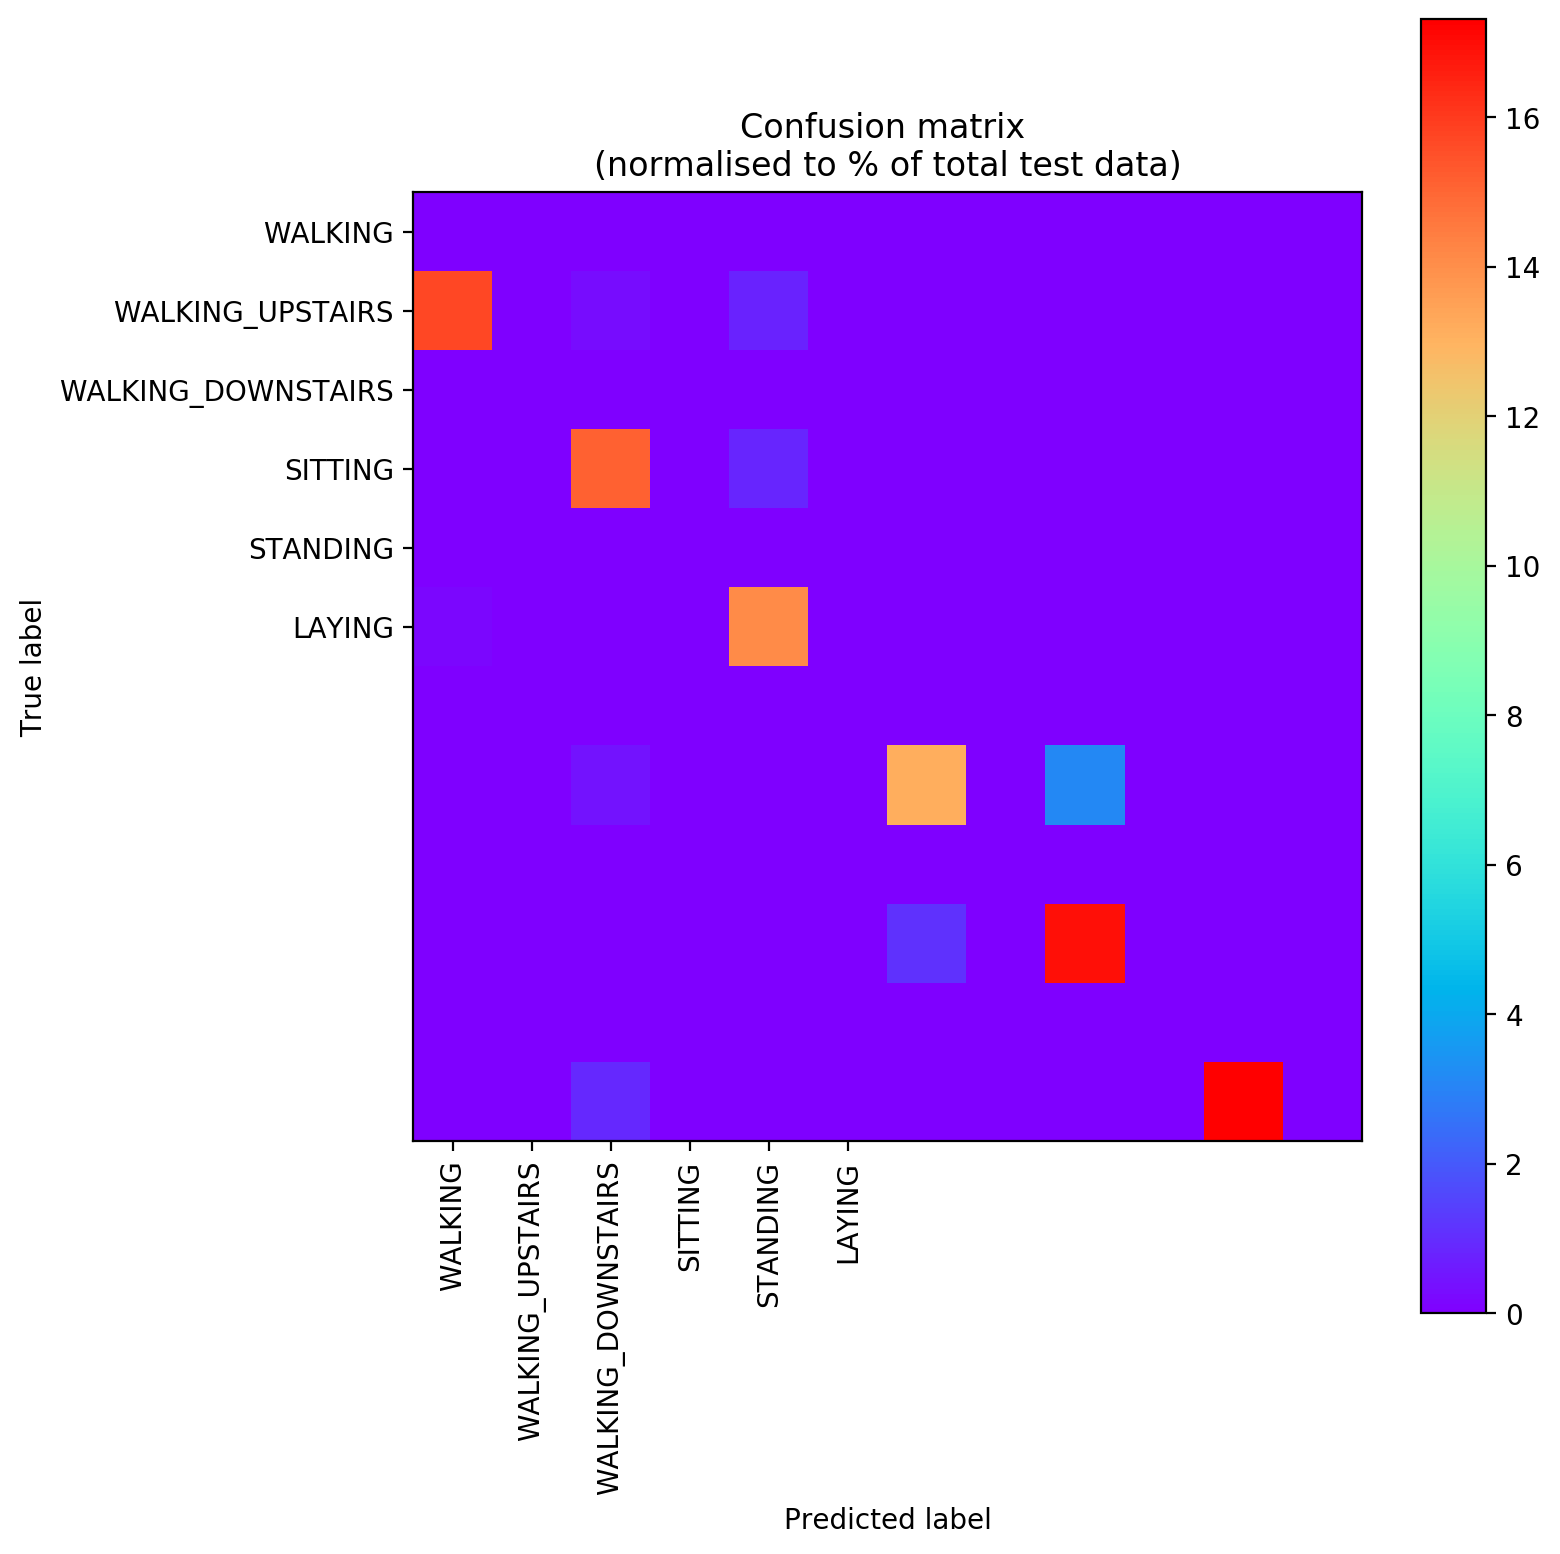

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_15 (TimeDis (None, None, 30, 64)      1792      
_________________________________________________________________
time_distributed_16 (TimeDis (None, None, 28, 64)      12352     
_________________________________________________________________
time_distributed_17 (TimeDis (None, None, 28, 64)      0         
_________________________________________________________________
time_distributed_18 (TimeDis (None, None, 14, 64)      0         
_________________________________________________________________
time_distributed_19 (TimeDis (None, None, 896)         0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               398800    
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)              

7352/7352 [==============================] - 2s 310us/sample - loss: 0.0439 - accuracy: 0.9777 - val_loss: 0.4692 - val_accuracy: 0.9013
Epoch 46/100
7352/7352 [==============================] - 2s 305us/sample - loss: 0.0445 - accuracy: 0.9788 - val_loss: 0.5085 - val_accuracy: 0.9033
Epoch 47/100
7352/7352 [==============================] - 2s 304us/sample - loss: 0.0396 - accuracy: 0.9796 - val_loss: 0.5452 - val_accuracy: 0.9013
Epoch 48/100
7352/7352 [==============================] - 2s 306us/sample - loss: 0.0355 - accuracy: 0.9810 - val_loss: 0.6328 - val_accuracy: 0.9009
Epoch 49/100
7352/7352 [==============================] - 2s 306us/sample - loss: 0.0336 - accuracy: 0.9845 - val_loss: 0.6387 - val_accuracy: 0.8918
Epoch 50/100
7352/7352 [==============================] - 2s 309us/sample - loss: 0.0495 - accuracy: 0.9762 - val_loss: 0.5333 - val_accuracy: 0.9009
Epoch 51/100
7352/7352 [==============================] - 2s 309us/sample - loss: 0.0346 - accuracy: 0.9837 - val

Epoch 100/100
2947/2947 [==============================] - 0s 111us/sample - loss: 0.4537 - accuracy: 0.9230
model.metrics_names:['loss', 'accuracy']
history.history:{'loss': [0.6420485609828194, 0.22002419120793243, 0.1558952922968273, 0.13370186212078403, 0.12247282396333133, 0.10775698360635355, 0.10506358399776432, 0.12492430244974784, 0.10078481888809972, 0.09681771126483547, 0.09724620361614798, 0.08859397965494514, 0.10162783930558504, 0.09437238395019507, 0.08784845753109753, 0.09297185599139128, 0.07885338156458732, 0.08342177760143794, 0.06792213623862921, 0.09017140399644372, 0.0749267055222337, 0.06831173466617835, 0.06554503570248954, 0.06528386112882212, 0.08351107759723467, 0.061660843196003755, 0.08009658697931758, 0.05726792979113944, 0.060273317804598575, 0.0586954478318352, 0.06093316605077475, 0.05705561052290348, 0.051428910312410016, 0.04806744728553574, 0.07126564556434832, 0.05746600349657684, 0.05174272624579166, 0.05057661478955935, 0.05050676344398316, 0.0432

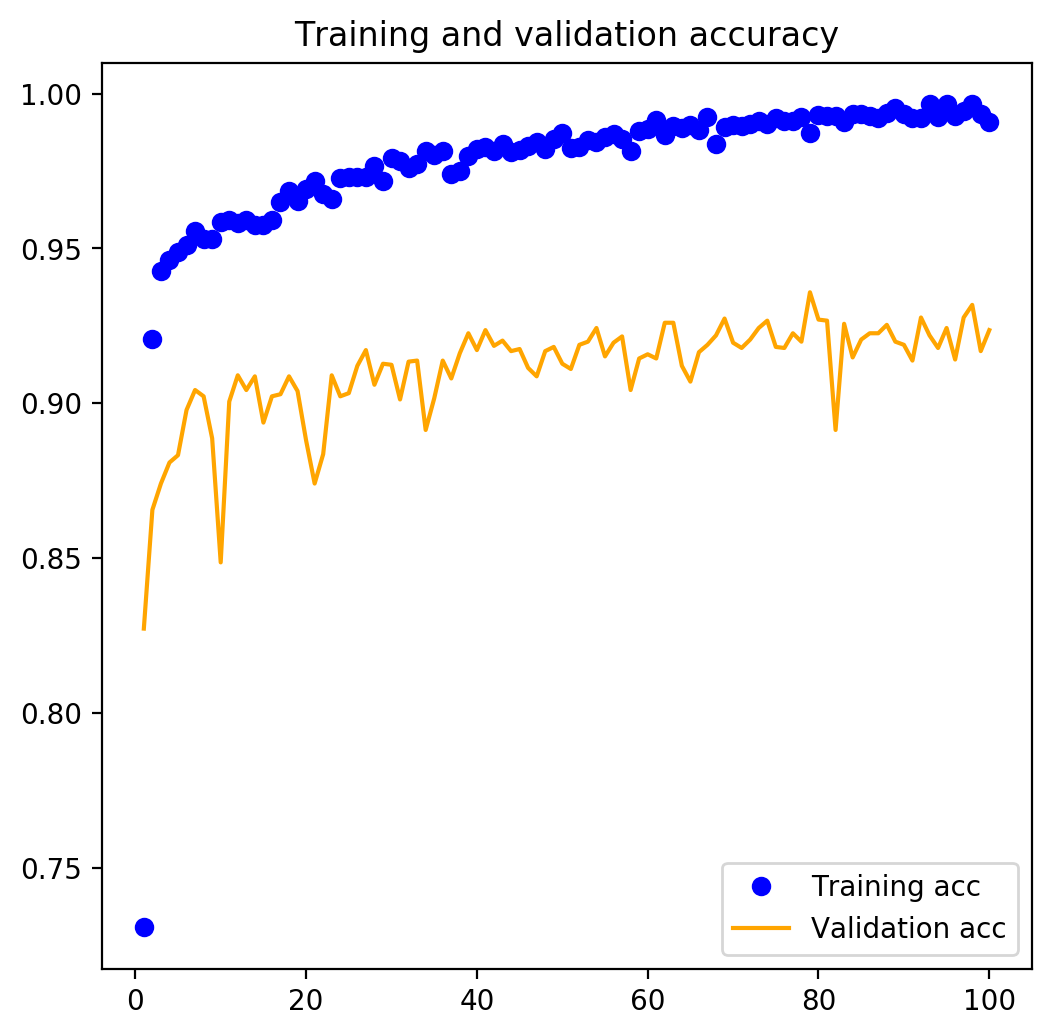

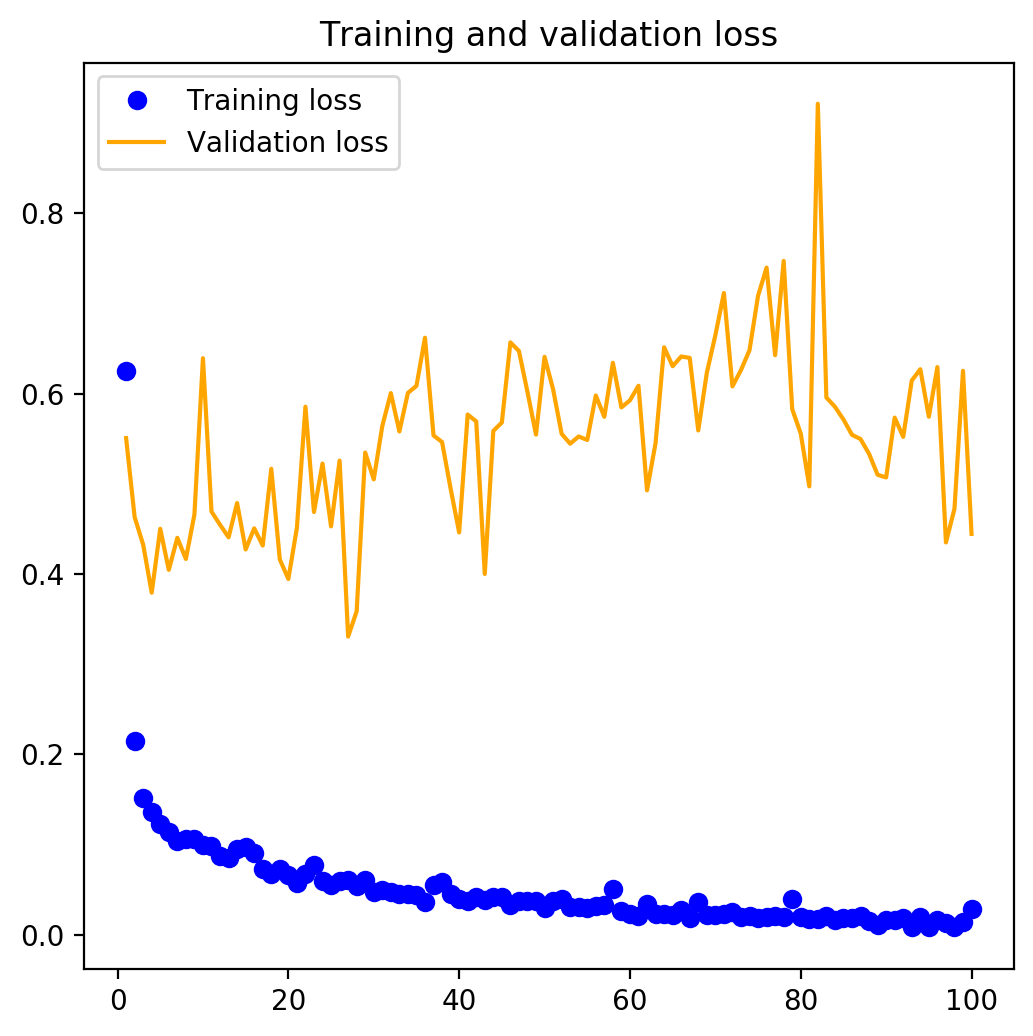

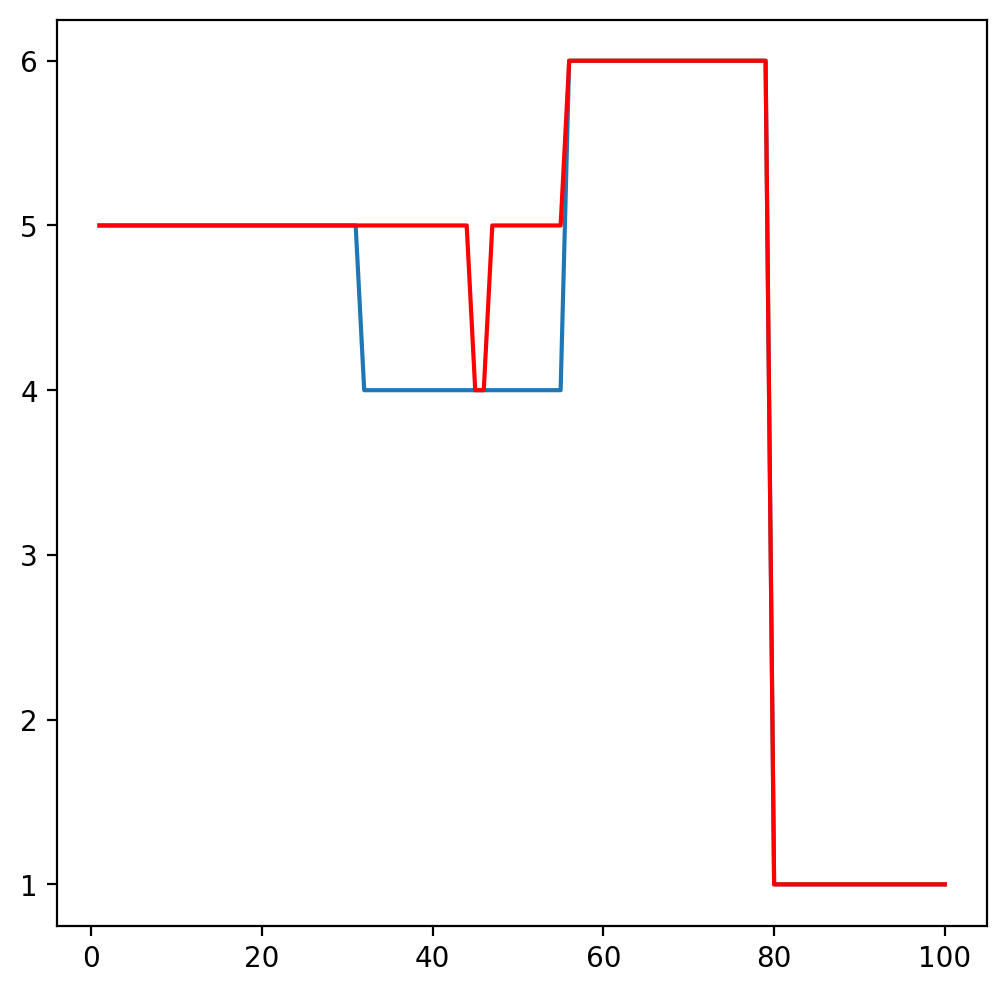

Confusion Matrix:
[[  0   0   0   0   0   0   0   0   0   0   0   0]
 [479   0   0   0  17   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [ 17   0 431   0  23   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 420   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   9   0   0   0 402   0  77   0   3   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  2   0   2   0   0   0  53   0 475   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  24   0   0   0   0   0   0   0 513   0]]
[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [16.253817    0.          0.          0.          0.5768578   0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.    

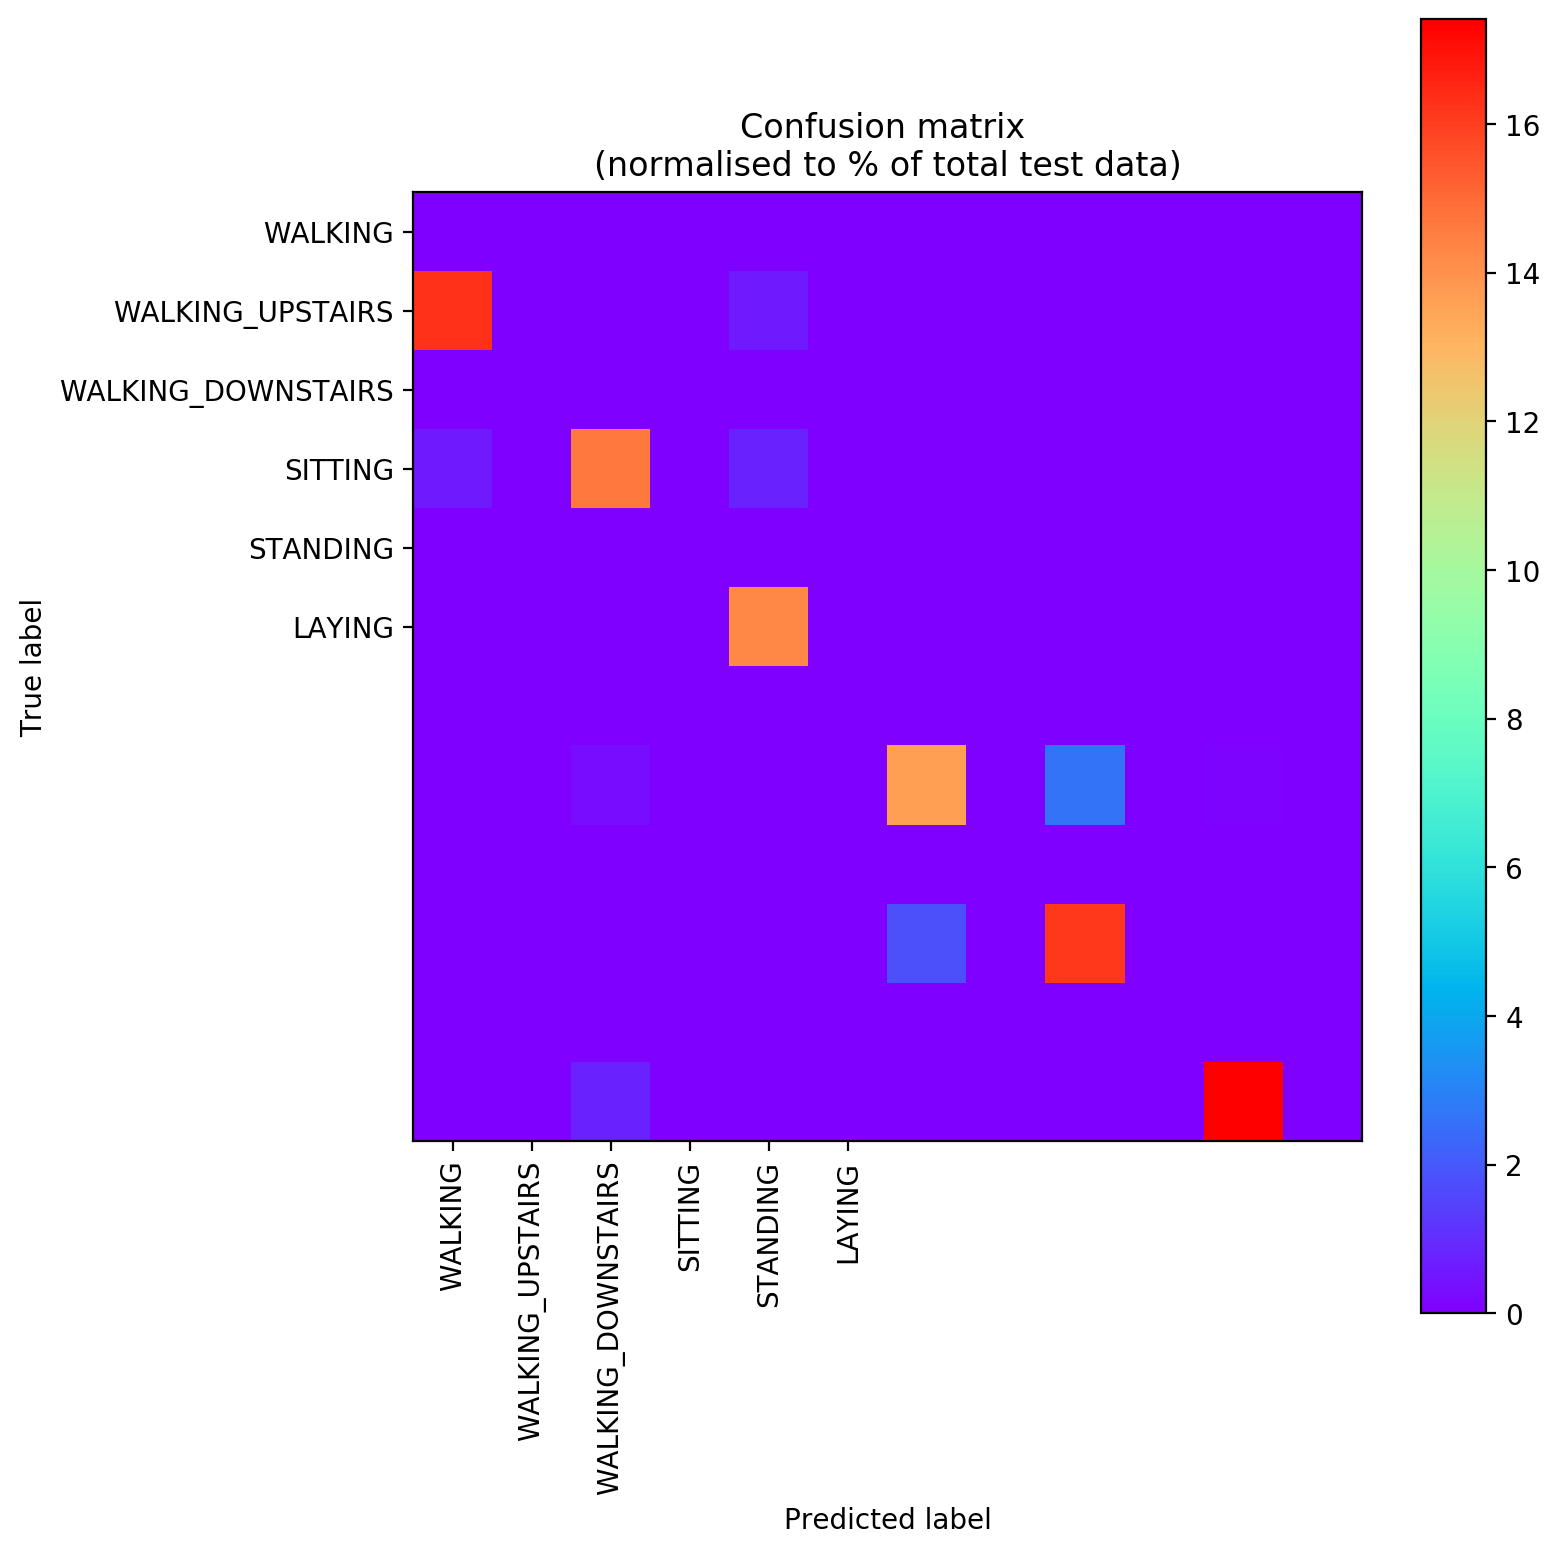

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_20 (TimeDis (None, None, 30, 64)      1792      
_________________________________________________________________
time_distributed_21 (TimeDis (None, None, 28, 64)      12352     
_________________________________________________________________
time_distributed_22 (TimeDis (None, None, 28, 64)      0         
_________________________________________________________________
time_distributed_23 (TimeDis (None, None, 14, 64)      0         
_________________________________________________________________
time_distributed_24 (TimeDis (None, None, 896)         0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               398800    
_________________________________________________________________
dropout_9 (Dropout)          (None, 100)              

7352/7352 [==============================] - 2s 310us/sample - loss: 0.0405 - accuracy: 0.9805 - val_loss: 0.5126 - val_accuracy: 0.9172
Epoch 46/100
7352/7352 [==============================] - 2s 308us/sample - loss: 0.0369 - accuracy: 0.9822 - val_loss: 0.5711 - val_accuracy: 0.9145
Epoch 47/100
7352/7352 [==============================] - 2s 308us/sample - loss: 0.0416 - accuracy: 0.9803 - val_loss: 0.5482 - val_accuracy: 0.9067
Epoch 48/100
7352/7352 [==============================] - 2s 309us/sample - loss: 0.0398 - accuracy: 0.9820 - val_loss: 0.5923 - val_accuracy: 0.9162
Epoch 49/100
7352/7352 [==============================] - 2s 309us/sample - loss: 0.0415 - accuracy: 0.9788 - val_loss: 0.5536 - val_accuracy: 0.9179
Epoch 50/100
7352/7352 [==============================] - 2s 313us/sample - loss: 0.0395 - accuracy: 0.9797 - val_loss: 0.6636 - val_accuracy: 0.9145
Epoch 51/100
7352/7352 [==============================] - 2s 307us/sample - loss: 0.0402 - accuracy: 0.9822 - val

Epoch 100/100
2947/2947 [==============================] - 0s 111us/sample - loss: 0.8012 - accuracy: 0.9284
model.metrics_names:['loss', 'accuracy']
history.history:{'loss': [0.5984610865891823, 0.21682124931093658, 0.1525496151440162, 0.1310530638279671, 0.11886225689012027, 0.12109857049321714, 0.11111111501160852, 0.12102292311074814, 0.11687301241988327, 0.09767058289025113, 0.10525985150086219, 0.10933584399659174, 0.0976539171089026, 0.10814022117165668, 0.10226062405145077, 0.09803784653641713, 0.09460636906901433, 0.085370236077428, 0.09127902949757882, 0.09167131071381263, 0.0863677464401242, 0.08366323568097137, 0.08376799993038632, 0.07966327575624184, 0.07301730742846273, 0.0744162674778434, 0.06847943539880176, 0.06965780312092053, 0.06748377896999379, 0.059451897787710525, 0.05947915578546799, 0.05944404702418777, 0.07398278848496109, 0.05752131390315404, 0.05852828120510778, 0.057781808564725194, 0.05371718561039656, 0.05486765452503542, 0.05390018494282895, 0.051941676

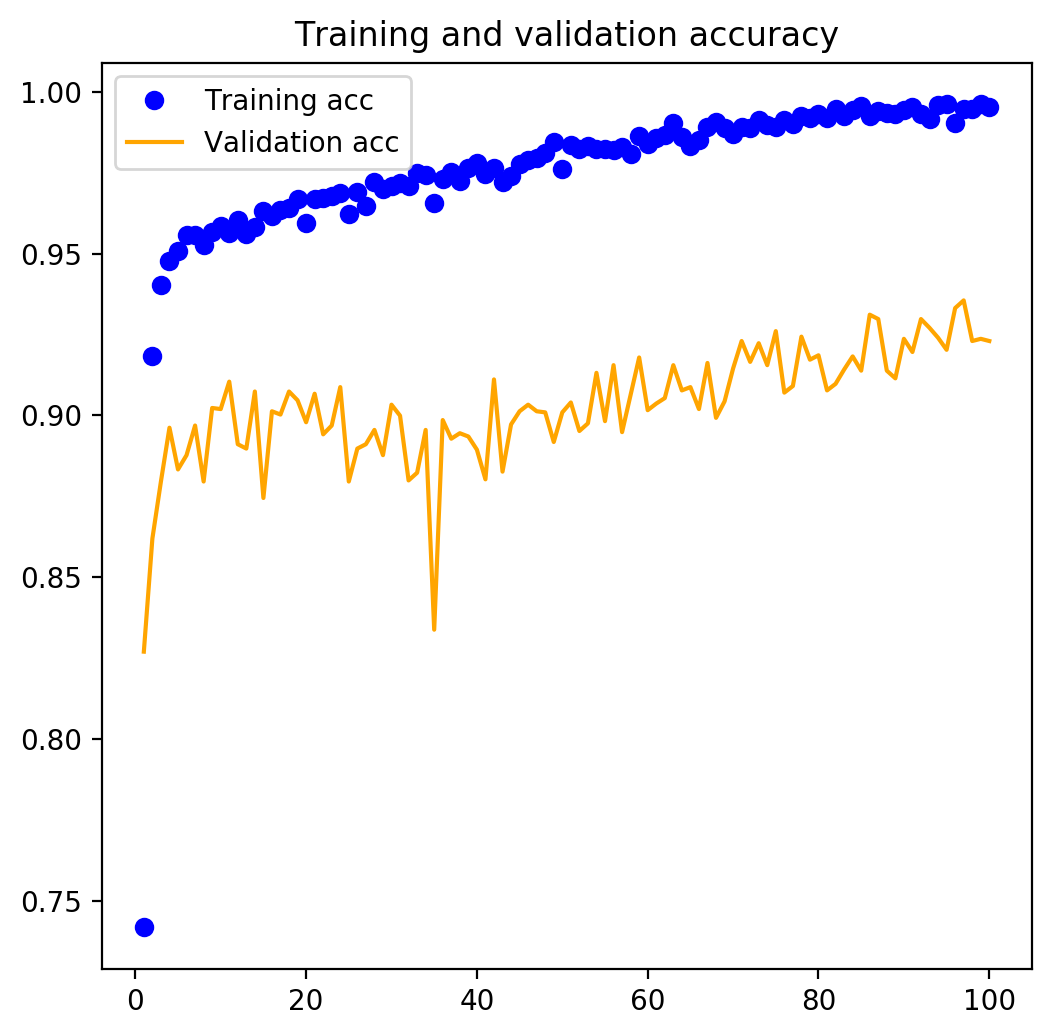

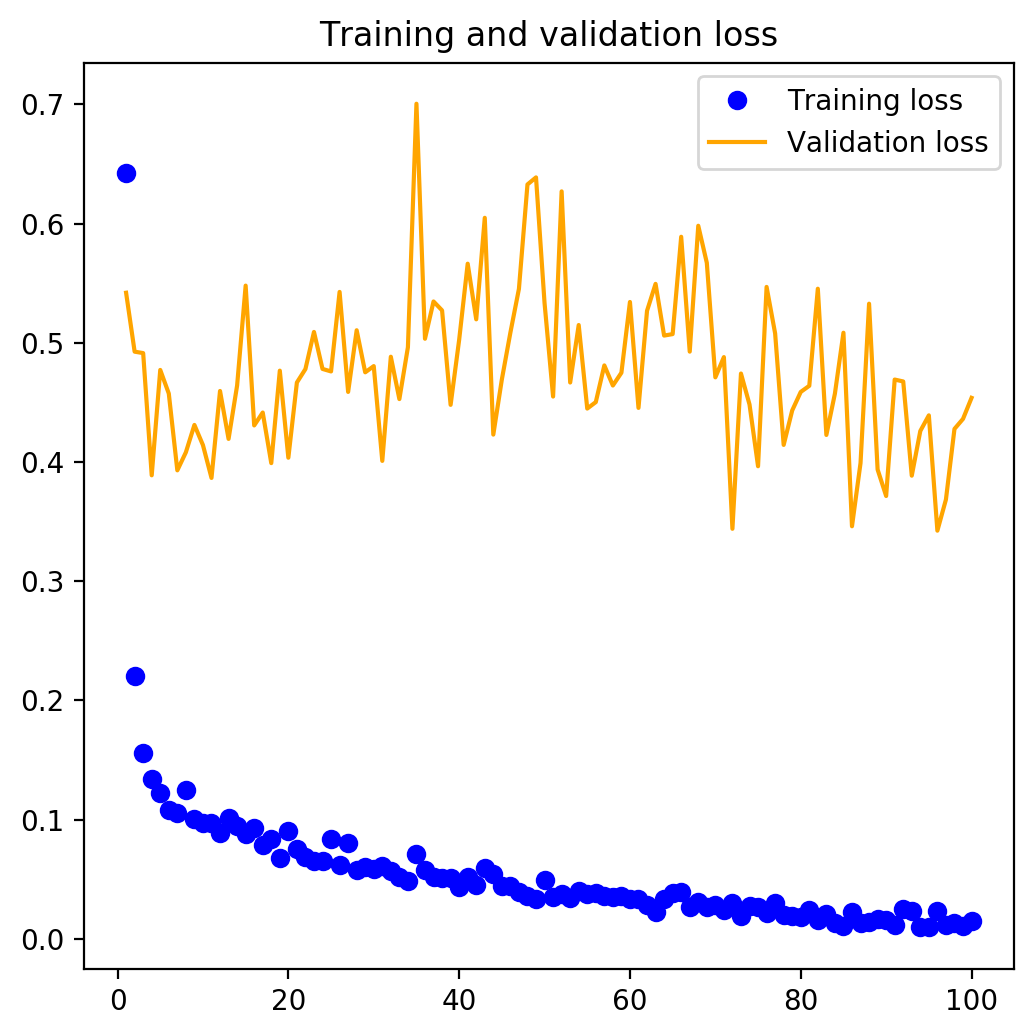

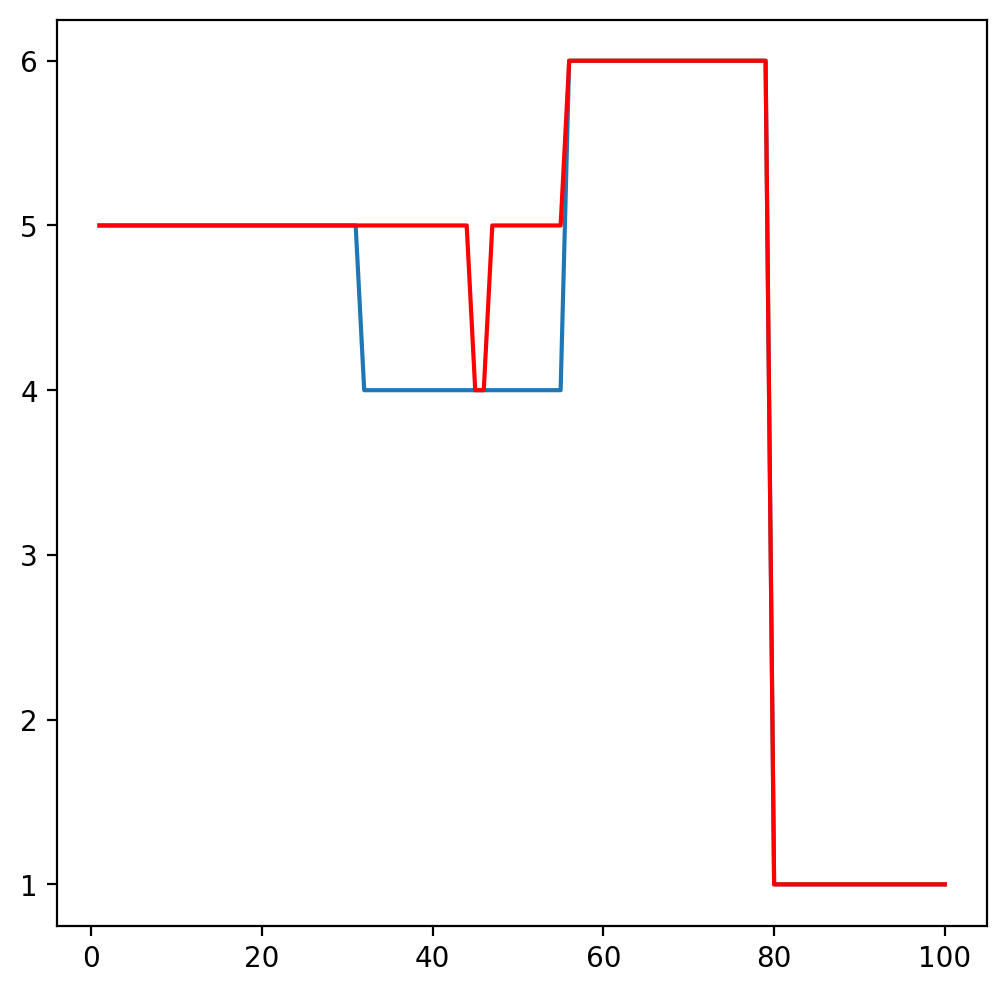

Confusion Matrix:
[[  0   0   0   0   0   0   0   0   0   0   0   0]
 [472   0   2   0  22   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  5   0 442   0  24   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  8   0   0   0 412   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  1   0  10   0   0   0 400   0  80   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  32   0 500   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  27   0   0   0   0   0   0   0 510   0]]
[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [16.016289    0.          0.06786563  0.          0.7465219   0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.    

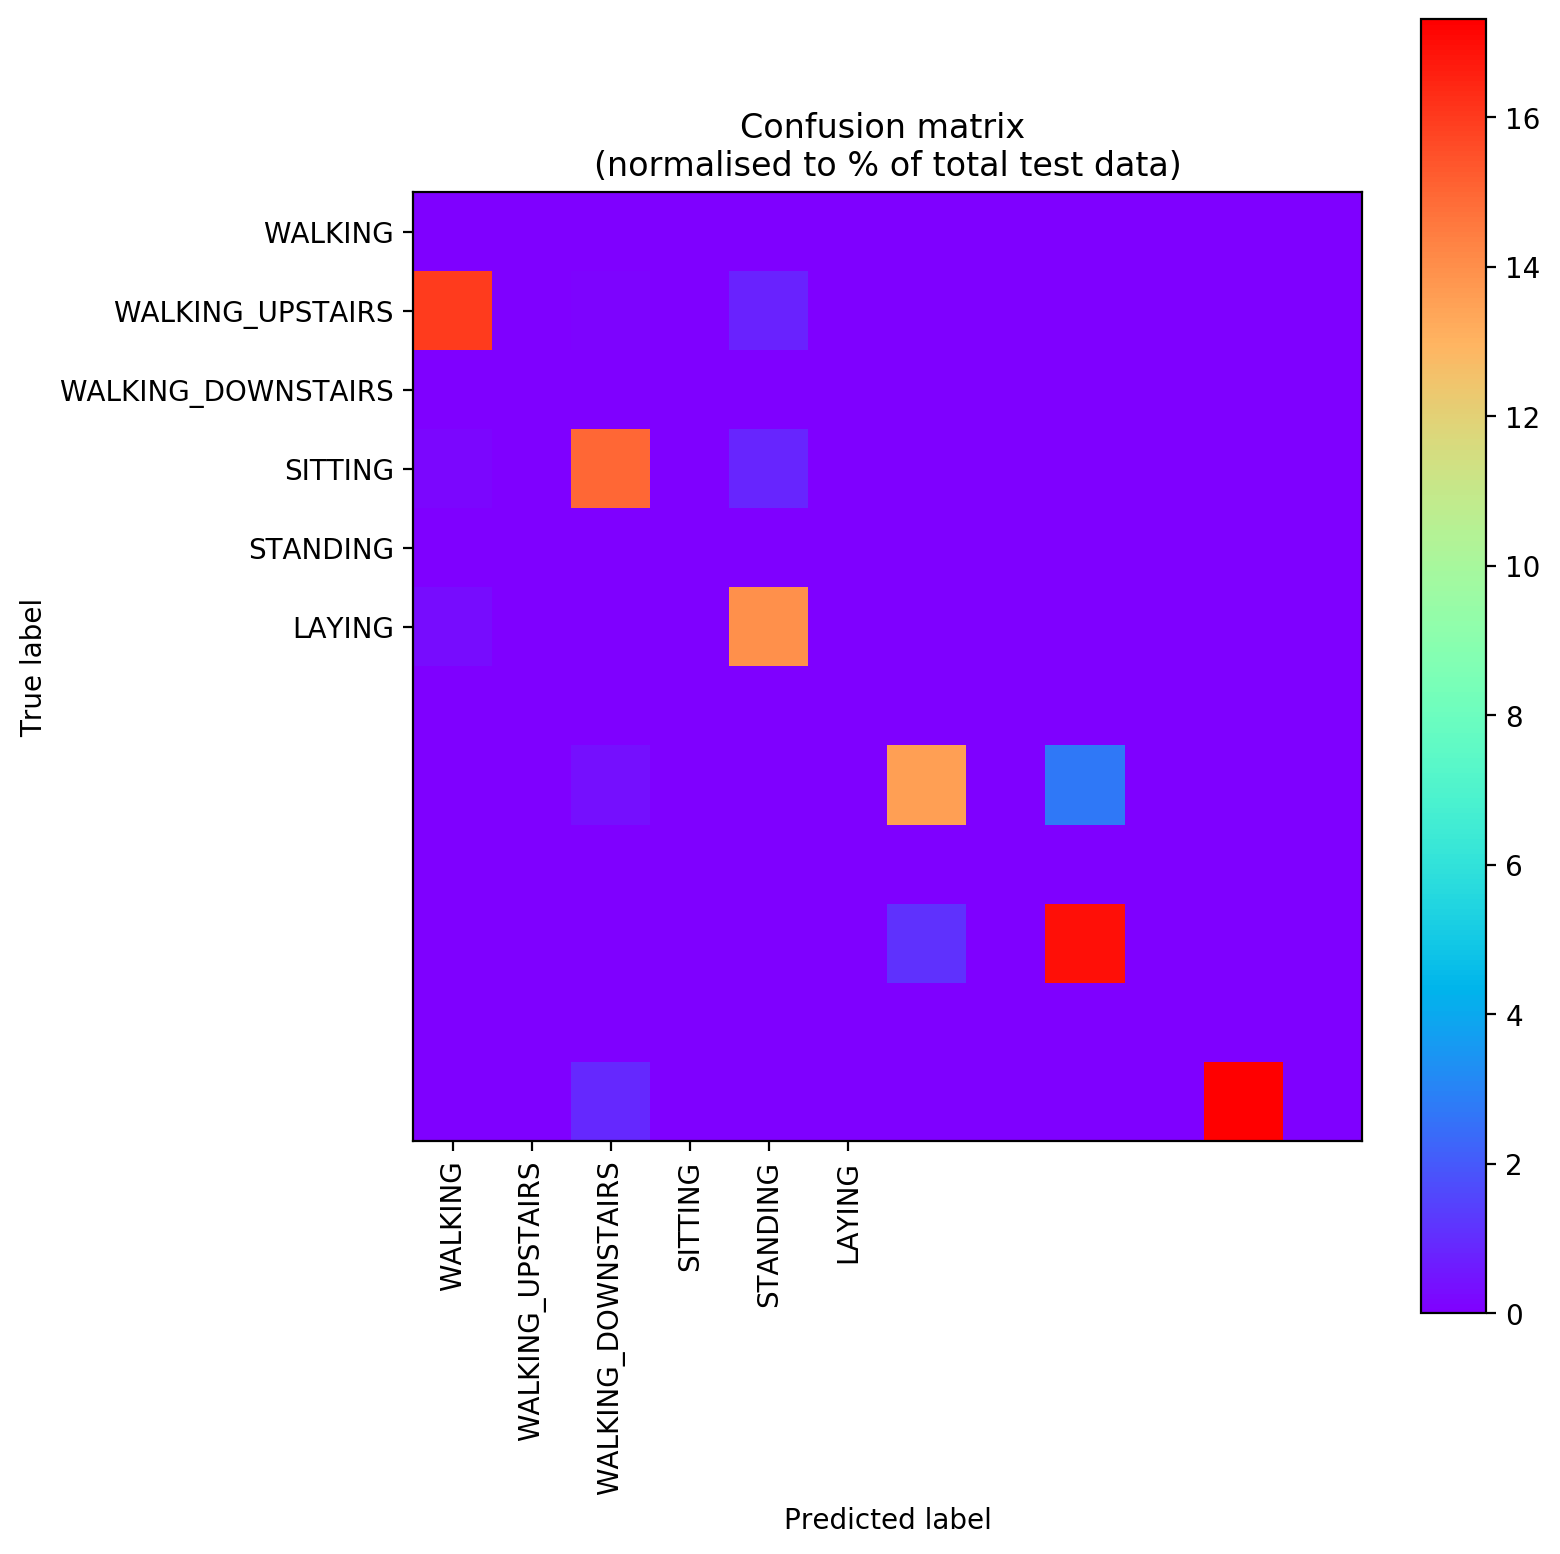

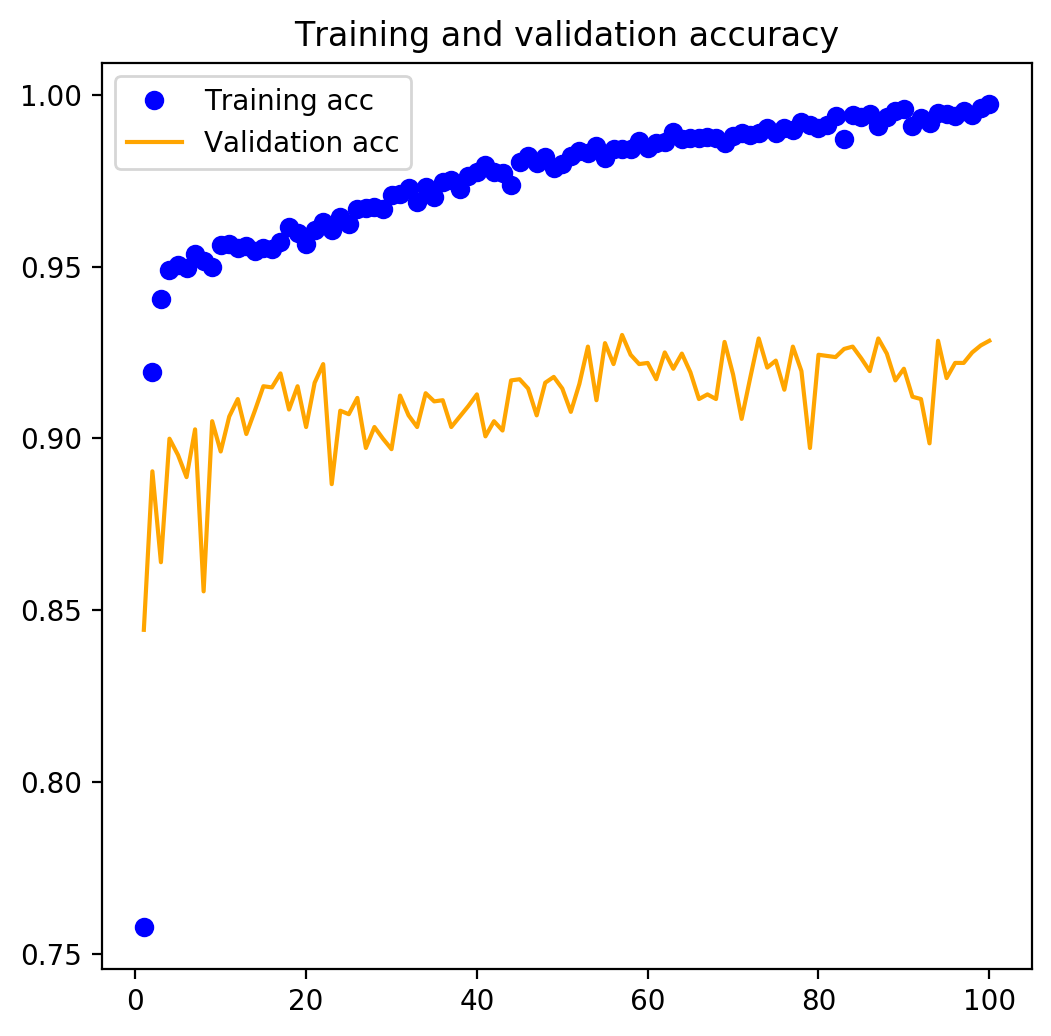

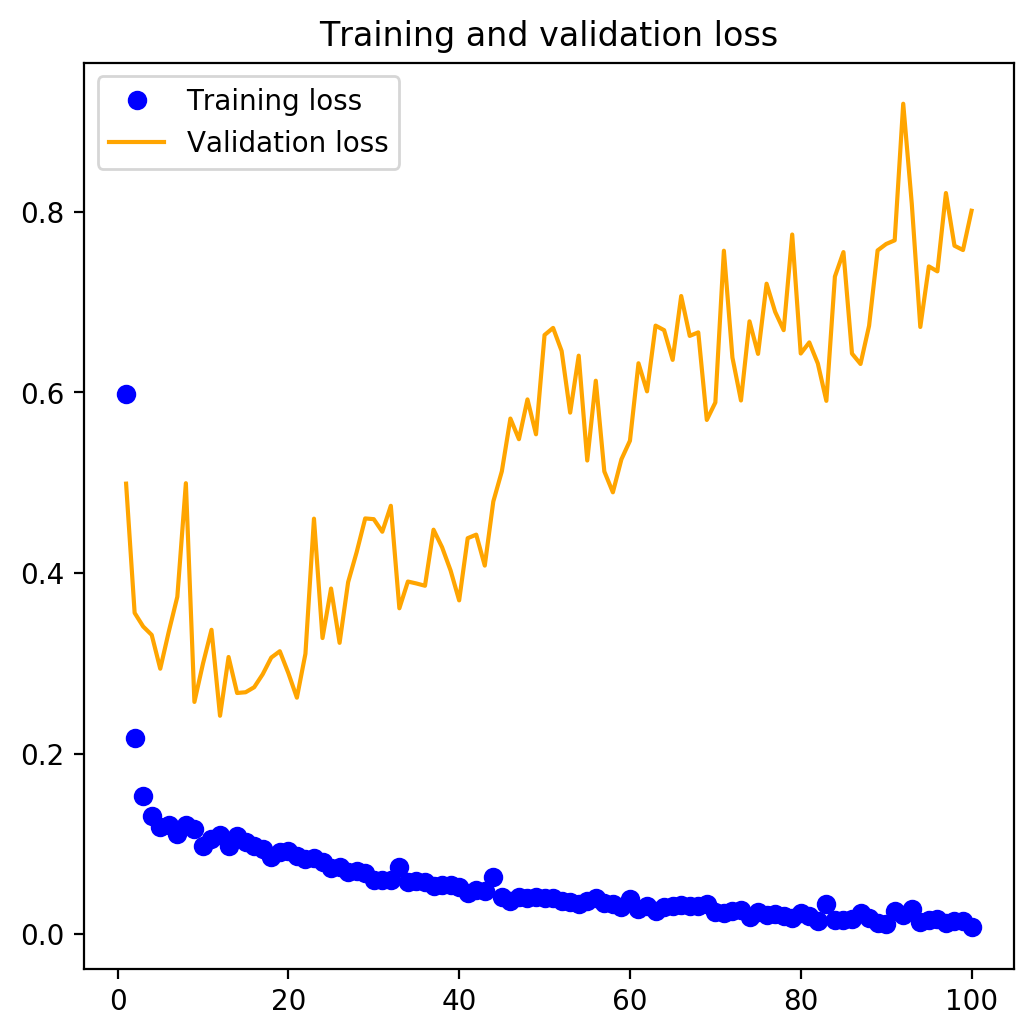

In [14]:
run_experiment()

In [15]:
import pandas as pd
df = pd.read_csv('uci_har_cnn-lstm_predictions_trans2.txt', sep=" ", header=None, names=["Prediction"])
temp_dict={0:'Walking',
           1:'Walking-upstairs',
           2:'Walking-downstairs',
           3:'Sitting',
           4:'Standing',
           5:'Laying'}

df['Prediction']=df.Prediction.map(temp_dict)
df

,Prediction
0,Standing
1,Standing
2,Standing
3,Standing
4,Standing
...,...
2942,Walking-upstairs
2943,Walking-upstairs
2944,Walking-upstairs
2945,Walking-upstairs


In [16]:
df.to_csv(r'uci_har_cnn-lstm_activity_predictions2.txt', header=None, index=None, sep='\t', mode='a')